## RNA3D Data Pipeline

Credit goes to this notebook and author --> https://www.kaggle.com/code/fernandosr85/rna-3d-structure


In [1]:
import os
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import traceback  # Add this import
from sklearn.model_selection import train_test_split

# Inicializando a semente para controlar a aleatoriedade
np.random.seed(0)

# Diretórios e arquivos ajustados para a nova competição
DATA_DIR = os.getenv('DATA_DIR', '/kaggle/input/stanford-rna-3d-folding/')
main_files = [
    "train_sequences.csv", 
    "train_labels.csv", 
    "validation_sequences.csv", 
    "validation_labels.csv", 
    "test_sequences.csv",
    "sample_submission.csv"
]

DEFAULT_THRESHOLD = 0.45# Limiar padrão após análise

def optimize_dataframe(df, inplace=False, category_threshold=DEFAULT_THRESHOLD):
    """
    Otimiza o DataFrame para economizar memória.
    """
    if category_threshold < 0 or category_threshold > 1:
        raise ValueError("category_threshold deve estar entre 0 e 1.")
    
    if not inplace:
        df = df.copy()
    
    for col in df.columns:
        col_type = df[col].dtype
        if np.issubdtype(col_type, np.integer):
            c_min, c_max = df[col].min(), df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        elif np.issubdtype(col_type, np.floating):
            if df[col].min() > np.finfo(np.float32).min and df[col].max() < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
        if col_type == object:
            unique_vals = len(df[col].unique())
            if unique_vals / len(df) < category_threshold:
                df[col] = df[col].astype('category')
    
    return df

def load_main_data(chunksize=50000):
    """
    Carrega os arquivos principais.
    """
    data = {}
    for file_name in main_files:
        file_path = os.path.join(DATA_DIR, file_name)
        if os.path.exists(file_path):
            chunks = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False, chunksize=chunksize)
            dataframes = [optimize_dataframe(chunk, category_threshold=DEFAULT_THRESHOLD) for chunk in chunks]
            data[file_name] = pd.concat(dataframes, ignore_index=True)
        else:
            print(f"Arquivo {file_path} não encontrado!")
    return data

def check_data_integrity(original_df, optimized_df):
    """
    Verifica se a otimização não alterou os dados.
    """
    try:
        pd.testing.assert_frame_equal(original_df, optimized_df, check_like=True)
        print("Integrity check passed: No changes in data after optimization.")
    except AssertionError as e:
        print(f"Data integrity check failed: {e}")

def check_duplicates(df):
    """
    Verifica duplicatas no DataFrame.
    """
    duplicates = df[df.duplicated(keep=False)]
    if not duplicates.empty:
        print(f"Warning: Duplicates found in the dataset. Number of duplicates: {duplicates.shape[0]}")
        return duplicates
    else:
        print("No duplicates found.")
    return None

def test_thresholds(df):
    """
    Testa diferentes limiares para otimização do DataFrame.
    """
    thresholds = np.linspace(0.1, 0.9, 9)
    memory_usages = []
    for threshold in thresholds:
        optimized_df = optimize_dataframe(df.copy(), category_threshold=threshold)
        memory_usages.append(optimized_df.memory_usage(deep=True).sum() / 1024**2)
    return thresholds, memory_usages

def plot_memory_usage(thresholds, memory_usages):
    """
    Plota o uso de memória versus limiares.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, memory_usages, marker='o', linestyle='-')
    plt.title("Memory Usage vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Memory Usage (MB)")
    plt.grid(True)
    plt.show()

def analyze_sequence_data(df_sequences):
    """
    Analisa os dados de sequências RNA.
    """
    # Informações básicas
    print(f"Total de sequências: {len(df_sequences)}")
    print(f"Colunas disponíveis: {df_sequences.columns.tolist()}")
    
    # Análise das sequências
    if 'sequence' in df_sequences.columns:
        # Distribuição de tamanho das sequências
        seq_lengths = df_sequences['sequence'].apply(len)
        print(f"\nEstatísticas de comprimento das sequências:")
        print(f"Mínimo: {seq_lengths.min()}")
        print(f"Máximo: {seq_lengths.max()}")
        print(f"Média: {seq_lengths.mean():.2f}")
        
        # Contagem de nucleotídeos
        nucleotides = ['A', 'C', 'G', 'U']
        nucleotide_counts = {n: df_sequences['sequence'].str.count(n).sum() for n in nucleotides}
        total_nucleotides = sum(nucleotide_counts.values())
        
        print("\nDistribuição de nucleotídeos:")
        for n, count in nucleotide_counts.items():
            print(f"{n}: {count} ({count/total_nucleotides*100:.2f}%)")
    
    return df_sequences

def analyze_label_data(df_labels):
    """
    Analisa os dados de coordenadas 3D (labels).
    """
    print(f"Total de entradas nas labels: {len(df_labels)}")
    print(f"Colunas disponíveis: {df_labels.columns.tolist()}")
    
    # Análise das coordenadas 3D se disponíveis
    coord_columns = [col for col in df_labels.columns if col.startswith(('x_', 'y_', 'z_'))]
    if coord_columns:
        print(f"\nColunas de coordenadas encontradas: {len(coord_columns)}")
        
        # Estatísticas básicas das coordenadas
        for i in range(1, 6):  # Para as 5 estruturas possíveis
            x_col = f'x_{i}'
            y_col = f'y_{i}'
            z_col = f'z_{i}'
            
            if x_col in df_labels.columns and y_col in df_labels.columns and z_col in df_labels.columns:
                print(f"\nEstatísticas para estrutura {i}:")
                print(f"X - Média: {df_labels[x_col].mean():.2f}, Desvio: {df_labels[x_col].std():.2f}")
                print(f"Y - Média: {df_labels[y_col].mean():.2f}, Desvio: {df_labels[y_col].std():.2f}")
                print(f"Z - Média: {df_labels[z_col].mean():.2f}, Desvio: {df_labels[z_col].std():.2f}")
    
    return df_labels

def create_submission_template(test_df, sample_submission_df):
    """
    Cria um template para submissão com base nos dados de teste.
    """
    # Verifica se o arquivo sample_submission.csv está disponível
    if sample_submission_df is None:
        print("Arquivo de submissão de exemplo não encontrado. Criando um novo template.")
        
        # Cria um novo DataFrame para submissão
        submission_df = pd.DataFrame()
        
        # Exemplo de código para preencher o template (ajustar conforme necessário)
        ids = []
        resnames = []
        resids = []
        
        for _, row in test_df.iterrows():
            sequence = row['sequence']
            target_id = row['target_id']
            
            for i, nucleotide in enumerate(sequence, 1):
                ids.append(f"{target_id}_{i}")
                resnames.append(nucleotide)
                resids.append(i)
        
        submission_df['ID'] = ids
        submission_df['resname'] = resnames
        submission_df['resid'] = resids
        
        # Adiciona colunas de coordenadas (5 estruturas)
        for i in range(1, 6):
            submission_df[f'x_{i}'] = 0.0
            submission_df[f'y_{i}'] = 0.0
            submission_df[f'z_{i}'] = 0.0
    else:
        submission_df = sample_submission_df.copy()
        print("Template de submissão criado com base no exemplo fornecido.")
    
    return submission_df

def main():
    start_time = time.time()
    
    # Carregar dados principais
    print("Carregando dados principais...")
    main_data = load_main_data()
    
    # Verificar quais arquivos foram carregados
    print("\nArquivos carregados:")
    for file_name, df in main_data.items():
        print(f"- {file_name}: {df.shape if df is not None else 'Não encontrado'}")
    
    # Analisar dados de sequências de treinamento
    if "train_sequences.csv" in main_data:
        print("\n===== Análise das Sequências de Treinamento =====")
        analyze_sequence_data(main_data["train_sequences.csv"])
    
    # Analisar dados de labels de treinamento
    if "train_labels.csv" in main_data:
        print("\n===== Análise das Labels de Treinamento =====")
        analyze_label_data(main_data["train_labels.csv"])
    
    # Verificação de duplicatas nos dados de treinamento
    if "train_sequences.csv" in main_data:
        print("\nVerificando duplicatas nas sequências de treinamento...")
        check_duplicates(main_data["train_sequences.csv"])
    
    # Criar template para submissão
    if "test_sequences.csv" in main_data:
        print("\nCriando template para submissão...")
        submission_template = create_submission_template(
            main_data["test_sequences.csv"],
            main_data.get("sample_submission.csv")
        )
        print(f"Shape do template de submissão: {submission_template.shape}")
        print(f"Primeiras linhas do template de submissão:")
        print(submission_template.head())
    
    # Calcular tempo de execução
    end_time = time.time()
    print(f"\nRuntime: {end_time - start_time:.2f} seconds")
    
    return main_data

if __name__ == '__main__':
    main_data = main()

Carregando dados principais...

Arquivos carregados:
- train_sequences.csv: (844, 5)
- train_labels.csv: (137095, 6)
- validation_sequences.csv: (12, 5)
- validation_labels.csv: (2515, 123)
- test_sequences.csv: (12, 5)
- sample_submission.csv: (2515, 18)

===== Análise das Sequências de Treinamento =====
Total de sequências: 844
Colunas disponíveis: ['target_id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']

Estatísticas de comprimento das sequências:
Mínimo: 3
Máximo: 4298
Média: 162.43

Distribuição de nucleotídeos:
A: 32524 (23.72%)
C: 33937 (24.76%)
G: 41450 (30.24%)
U: 29178 (21.28%)

===== Análise das Labels de Treinamento =====
Total de entradas nas labels: 137095
Colunas disponíveis: ['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1']

Colunas de coordenadas encontradas: 3

Estatísticas para estrutura 1:
X - Média: 80.45, Desvio: 147.42
Y - Média: 84.04, Desvio: 114.93
Z - Média: 98.61, Desvio: 119.41

Verificando duplicatas nas sequências de treinamento...
No du

## Explorador de Diretórios e Verificação de CSV RNA3D

In [2]:
import os

# Diretório principal atualizado
dir_main = "/kaggle/input/stanford-rna-3d-folding/"

# Lista todos os arquivos e diretórios no diretório principal
try:
    todos_arquivos = os.listdir(dir_main)
    print(f"Todos os arquivos e diretórios em '{dir_main}':")
    for arquivo in todos_arquivos:
        # Verifica se é um arquivo ou diretório
        path_completo = os.path.join(dir_main, arquivo)
        tipo = "diretório" if os.path.isdir(path_completo) else "arquivo"
        tamanho = os.path.getsize(path_completo) / 1024  # Tamanho em KB
        print(f" - {arquivo} ({tipo}, {tamanho:.2f} KB)")
        
        # Se for um diretório, lista até 5 arquivos dentro dele
        if os.path.isdir(path_completo):
            try:
                arquivos_internos = os.listdir(path_completo)[:5]  # Limita a 5 arquivos
                if arquivos_internos:
                    print(f"   Primeiros arquivos em '{arquivo}':")
                    for arq_interno in arquivos_internos:
                        print(f"    * {arq_interno}")
                    if len(os.listdir(path_completo)) > 5:
                        print(f"    * ... e mais {len(os.listdir(path_completo)) - 5} arquivo(s)")
                else:
                    print(f"   '{arquivo}' está vazio")
            except Exception as e:
                print(f"   Erro ao listar conteúdo de '{arquivo}': {e}")

except Exception as e:
    print(f"Erro ao listar o diretório {dir_main}: {e}")

# Verifica a estrutura dos principais arquivos CSV
principais_arquivos = [
    "train_sequences.csv", 
    "train_labels.csv", 
    "validation_sequences.csv", 
    "validation_labels.csv", 
    "test_sequences.csv",
    "sample_submission.csv"
]

print("\nVerificando os principais arquivos CSV:")
for arquivo in principais_arquivos:
    path_completo = os.path.join(dir_main, arquivo)
    if os.path.exists(path_completo):
        # Obtém o tamanho do arquivo
        tamanho_mb = os.path.getsize(path_completo) / (1024 * 1024)  # Tamanho em MB
        
        # Lê as primeiras linhas para verificar a estrutura
        try:
            import pandas as pd
            df = pd.read_csv(path_completo, nrows=1)
            print(f"\n{arquivo} ({tamanho_mb:.2f} MB):")
            print(f"Colunas: {df.columns.tolist()}")
            print(f"Exemplo:")
            print(df.head())
        except Exception as e:
            print(f"Erro ao ler {arquivo}: {e}")
    else:
        print(f"{arquivo} não encontrado.")

Todos os arquivos e diretórios em '/kaggle/input/stanford-rna-3d-folding/':
 - MSA (diretório, 0.00 KB)
   Primeiros arquivos em 'MSA':
    * R1108.MSA.fasta
    * 8EVR_EC.MSA.fasta
    * 1ZDI_S.MSA.fasta
    * 5FJ1_H.MSA.fasta
    * 2NBY_A.MSA.fasta
    * ... e mais 851 arquivo(s)
 - sample_submission.csv (arquivo, 184.51 KB)
 - validation_sequences.csv (arquivo, 9.76 KB)
 - MSA_v2 (diretório, 0.00 KB)
   Primeiros arquivos em 'MSA_v2':
    * 3JCS_6.MSA.fasta
    * 7MSF_R.MSA.fasta
    * 2OOM_B.MSA.fasta
    * 1ZDI_S.MSA.fasta
    * 5FJ1_H.MSA.fasta
    * ... e mais 2529 arquivo(s)
 - test_sequences.csv (arquivo, 9.76 KB)
 - train_labels.v2.csv (arquivo, 261923.90 KB)
 - validation_labels.csv (arquivo, 2431.67 KB)
 - train_labels.csv (arquivo, 9430.44 KB)
 - train_sequences.csv (arquivo, 2975.69 KB)
 - PDB_RNA (diretório, 0.00 KB)
   Primeiros arquivos em 'PDB_RNA':
    * 2d19.cif
    * 6oxi.cif
    * 7r6l.cif
    * 7evo.cif
    * 1hys.cif
    * ... e mais 8667 arquivo(s)
 - train_seq

## Checador de Dados RNA3D

In [3]:
# Diretório principal atualizado
dir_main = "/kaggle/input/stanford-rna-3d-folding/"

def load_data():
    """
    Carrega os principais arquivos CSV da competição Stanford RNA 3D Folding.
    Retorna um dicionário com os DataFrames.
    """
    main_files = [
        "train_sequences.csv", 
        "train_labels.csv", 
        "validation_sequences.csv", 
        "validation_labels.csv", 
        "test_sequences.csv",
        "sample_submission.csv"
    ]
    
    data = {}
    for file_name in main_files:
        file_path = os.path.join(dir_main, file_name)
        if os.path.exists(file_path):
            try:
                data[file_name] = pd.read_csv(file_path)
                print(f"Arquivo {file_name} carregado com sucesso. Shape: {data[file_name].shape}")
            except Exception as e:
                print(f"Erro ao carregar {file_name}: {e}")
        else:
            print(f"Arquivo {file_name} não encontrado.")
            data[file_name] = None
    
    return data

def compare_columns(main_data):
    """
    Compara as colunas entre diferentes DataFrames.
    """
    # Listar todas as chaves disponíveis
    print("\nArquivos carregados:")
    print(list(main_data.keys()))
    
    # Comparar colunas entre train_sequences.csv e test_sequences.csv
    if "train_sequences.csv" in main_data and "test_sequences.csv" in main_data:
        train_cols = set(main_data["train_sequences.csv"].columns)
        test_cols = set(main_data["test_sequences.csv"].columns)
        
        print("\nColunas em train_sequences.csv:")
        print(list(main_data["train_sequences.csv"].columns))
        
        print("\nColunas exclusivas em train_sequences.csv (não presentes em test_sequences.csv):")
        print(train_cols - test_cols)
        
        print("\nColunas exclusivas em test_sequences.csv (não presentes em train_sequences.csv):")
        print(test_cols - train_cols)
    
    # Comparar colunas entre train_labels.csv e validation_labels.csv
    if "train_labels.csv" in main_data and "validation_labels.csv" in main_data:
        train_label_cols = set(main_data["train_labels.csv"].columns)
        val_label_cols = set(main_data["validation_labels.csv"].columns)
        
        print("\nColunas em train_labels.csv:")
        print(list(main_data["train_labels.csv"].columns))
        
        print("\nColunas em validation_labels.csv:")
        print(list(main_data["validation_labels.csv"].columns))
        
        print("\nColunas exclusivas em validation_labels.csv (não presentes em train_labels.csv):")
        print(val_label_cols - train_label_cols)
    
    # Comparar colunas entre validation_labels.csv e sample_submission.csv
    if "validation_labels.csv" in main_data and "sample_submission.csv" in main_data:
        val_label_cols = set(main_data["validation_labels.csv"].columns)
        sample_cols = set(main_data["sample_submission.csv"].columns)
        
        print("\nColunas em sample_submission.csv:")
        print(list(main_data["sample_submission.csv"].columns))
        
        print("\nColunas exclusivas em validation_labels.csv (não presentes em sample_submission.csv):")
        print(val_label_cols - sample_cols)
        
        print("\nColunas exclusivas em sample_submission.csv (não presentes em validation_labels.csv):")
        print(sample_cols - val_label_cols)

def analyze_structure_format(main_data):
    """
    Analisa o formato das estruturas 3D (coordenadas).
    """
    if "validation_labels.csv" in main_data and main_data["validation_labels.csv"] is not None:
        df = main_data["validation_labels.csv"]
        
        # Encontrar todas as colunas de coordenadas (x_1, y_1, z_1, etc.)
        coord_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
        
        # Agrupar por estrutura
        structures = {}
        for col in coord_cols:
            # Extrair número da estrutura (e.g., "x_1" -> 1)
            parts = col.split('_')
            if len(parts) == 2:
                struct_num = int(parts[1])
                coord_type = parts[0]
                
                if struct_num not in structures:
                    structures[struct_num] = []
                
                structures[struct_num].append(col)
        
        print("\nEstrutura do arquivo de labels:")
        print(f"Total de estruturas encontradas: {len(structures)}")
        
        # Mostrar detalhes da primeira estrutura
        if structures:
            first_struct = min(structures.keys())
            print(f"\nDetalhe da estrutura {first_struct}:")
            print(f"Colunas: {sorted(structures[first_struct])}")
            
            # Verificar se há valores ausentes
            for col in structures[first_struct]:
                missing = df[col].isna().sum()
                total = len(df)
                print(f"{col}: {missing} valores ausentes ({missing/total*100:.2f}%)")
            
            # Verificar o range dos valores não-ausentes para a primeira estrutura
            for col in structures[first_struct]:
                non_null = df[col][df[col] != -1.0e+18]  # Valores que não são -1.0e+18
                if not non_null.empty:
                    print(f"{col} - Range: [{non_null.min():.3f}, {non_null.max():.3f}]")

def main():
    # Carregar os dados
    main_data = load_data()
    
    # Comparar colunas entre diferentes arquivos
    compare_columns(main_data)
    
    # Analisar o formato das estruturas 3D
    analyze_structure_format(main_data)
    
    return main_data

if __name__ == '__main__':
    main_data = main()

Arquivo train_sequences.csv carregado com sucesso. Shape: (844, 5)
Arquivo train_labels.csv carregado com sucesso. Shape: (137095, 6)
Arquivo validation_sequences.csv carregado com sucesso. Shape: (12, 5)
Arquivo validation_labels.csv carregado com sucesso. Shape: (2515, 123)
Arquivo test_sequences.csv carregado com sucesso. Shape: (12, 5)
Arquivo sample_submission.csv carregado com sucesso. Shape: (2515, 18)

Arquivos carregados:
['train_sequences.csv', 'train_labels.csv', 'validation_sequences.csv', 'validation_labels.csv', 'test_sequences.csv', 'sample_submission.csv']

Colunas em train_sequences.csv:
['target_id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']

Colunas exclusivas em train_sequences.csv (não presentes em test_sequences.csv):
set()

Colunas exclusivas em test_sequences.csv (não presentes em train_sequences.csv):
set()

Colunas em train_labels.csv:
['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1']

Colunas em validation_labels.csv:
['ID', 'resname', 'res

## Analisador Integrado de Sequências e Estruturas RNA3D

Arquivo train_sequences.csv carregado com sucesso. Shape: (844, 5)
Arquivo train_labels.csv carregado com sucesso. Shape: (137095, 6)
Arquivo validation_sequences.csv carregado com sucesso. Shape: (12, 5)
Arquivo validation_labels.csv carregado com sucesso. Shape: (2515, 123)
Arquivo test_sequences.csv carregado com sucesso. Shape: (12, 5)
Arquivo sample_submission.csv carregado com sucesso. Shape: (2515, 18)

Arquivos carregados:
- train_sequences.csv: (844, 5)
- train_labels.csv: (137095, 6)
- validation_sequences.csv: (12, 5)
- validation_labels.csv: (2515, 123)
- test_sequences.csv: (12, 5)
- sample_submission.csv: (2515, 18)

===== Análise das Estruturas 3D (validation_labels.csv) =====
Há 40 colunas x_ no DataFrame.
Há 40 colunas y_ no DataFrame.
Há 40 colunas z_ no DataFrame.

Colunas sem valores ausentes: 123
Colunas completamente vazias: 0
Número de colunas x: 40
Número de colunas y: 40
Número de colunas z: 40

Estrutura 1:
  Valores especiais: x=15 (0.60%), y=15 (0.60%), z=15

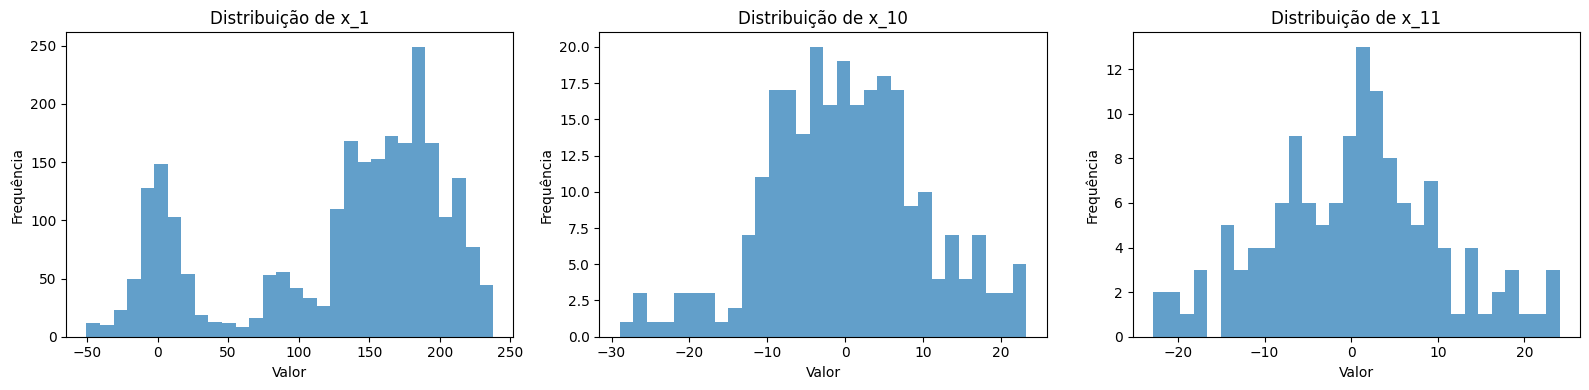


Distribuição das coordenadas Y:


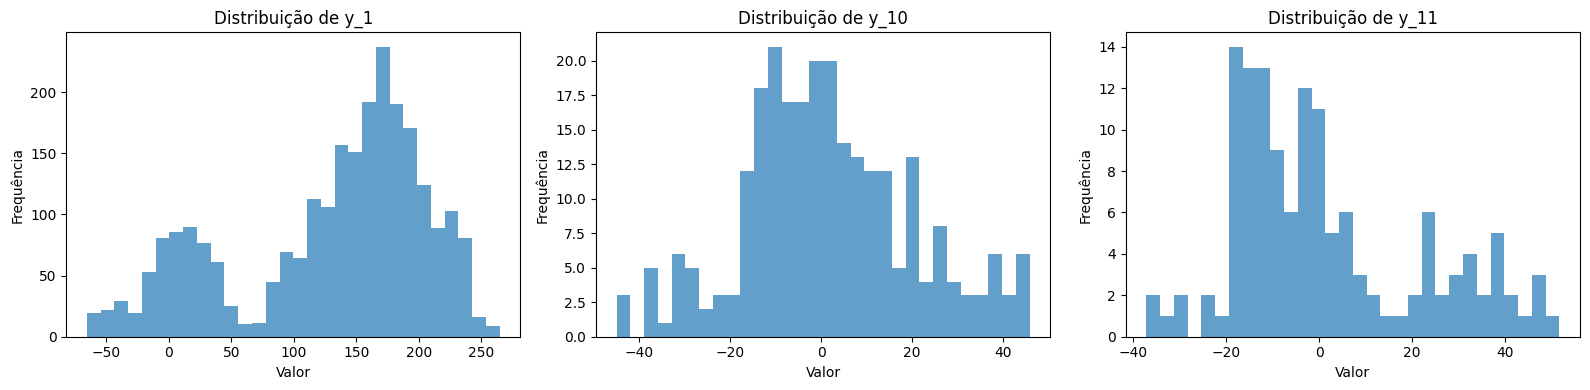


Distribuição das coordenadas Z:


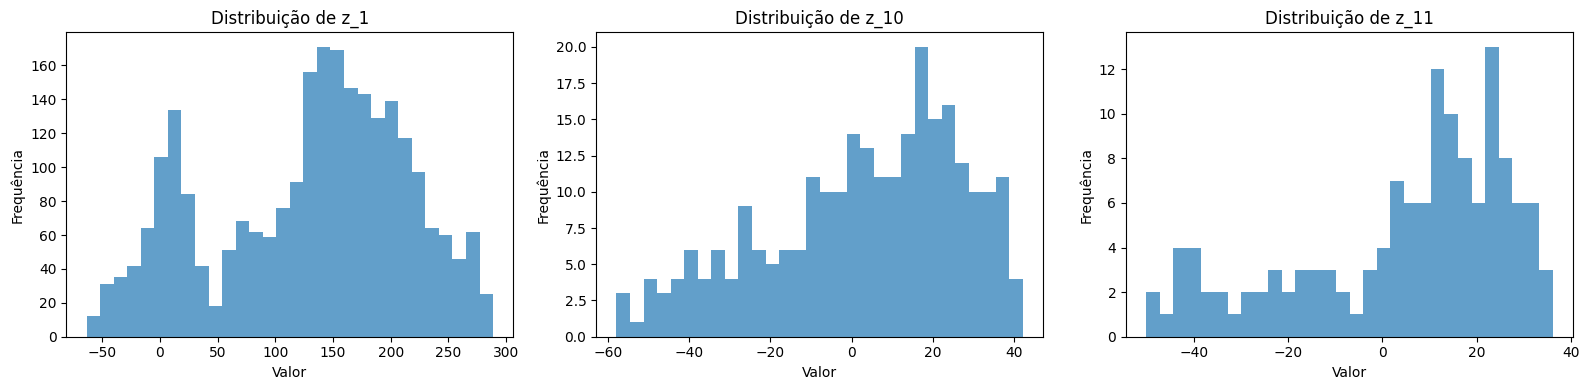


===== Análise das Sequências (train_sequences.csv) =====

Primeiras linhas da coluna 'sequence':
0         GGGUGCUCAGUACGAGAGGAACCGCACCC
1    GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
2              GGGACUGACGAUCACGCAGUCUAU
3                  GGGAUAACUUCGGUUGUCCC
4    GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU
Name: sequence, dtype: object

Tipo de dados da coluna 'sequence':
object

Estatísticas básicas da coluna 'sequence':
count                                                  844
unique                                                 784
top       UUUUUAAUUUCUACUCUUGUAGAUGUGAUAAGUGGAAUGCCAUGUGGA
freq                                                     5
Name: sequence, dtype: object

Estatísticas de comprimento das sequências:
Mínimo: 3
Máximo: 4298
Média: 162.43
Mediana: 39.5

Distribuição de nucleotídeos:
-: 4 (0.00%)
A: 32524 (23.72%)
C: 33937 (24.75%)
G: 41450 (30.23%)
U: 29178 (21.28%)
X: 2 (0.00%)


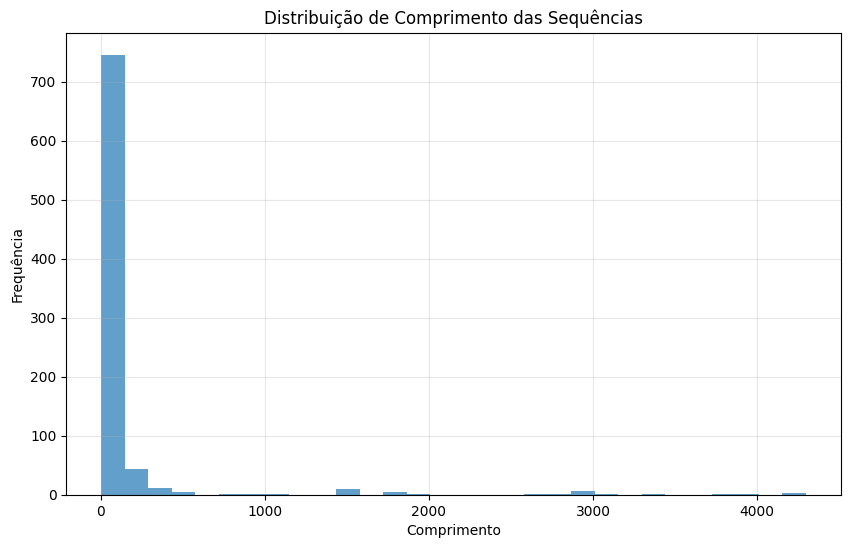

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import gc

# Inicializando a semente para controlar a aleatoriedade
np.random.seed(0)

# Diretórios e arquivos ajustados para a nova competição
DATA_DIR = os.getenv('DATA_DIR', '/kaggle/input/stanford-rna-3d-folding/')
main_files = [
    "train_sequences.csv", 
    "train_labels.csv", 
    "validation_sequences.csv", 
    "validation_labels.csv", 
    "test_sequences.csv",
    "sample_submission.csv"
]

DEFAULT_THRESHOLD = 0.4  # Limiar padrão após análise

def optimize_dataframe(df, inplace=False, category_threshold=DEFAULT_THRESHOLD):
    """
    Otimiza o DataFrame para economizar memória.
    """
    if category_threshold < 0 or category_threshold > 1:
        raise ValueError("category_threshold deve estar entre 0 e 1.")
    
    if not inplace:
        df = df.copy()
    
    for col in df.columns:
        col_type = df[col].dtype
        if np.issubdtype(col_type, np.integer):
            c_min, c_max = df[col].min(), df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        elif np.issubdtype(col_type, np.floating):
            # Verificar primeiro se não é o valor especial -1.0e+18
            if df[col].min() > np.finfo(np.float32).min and df[col].max() < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
        if col_type == object:
            unique_vals = len(df[col].unique())
            if unique_vals / len(df) < category_threshold:
                df[col] = df[col].astype('category')
    
    return df

def load_main_data(chunksize=50000):
    """
    Carrega os arquivos principais.
    """
    data = {}
    for file_name in main_files:
        file_path = os.path.join(DATA_DIR, file_name)
        if os.path.exists(file_path):
            chunks = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False, chunksize=chunksize)
            dataframes = [optimize_dataframe(chunk, category_threshold=DEFAULT_THRESHOLD) for chunk in chunks]
            data[file_name] = pd.concat(dataframes, ignore_index=True)
            print(f"Arquivo {file_name} carregado com sucesso. Shape: {data[file_name].shape}")
        else:
            print(f"Arquivo {file_path} não encontrado!")
            data[file_name] = None
    return data

def filter_columns_by_prefix(df, prefix="x_"):
    """
    Filtra e conta o número de colunas em um DataFrame com base em um prefixo fornecido.
    
    :param df: DataFrame onde a filtragem será aplicada.
    :param prefix: Prefixo a ser usado para a filtragem. Ex: "x_", "y_", "z_".
    :return: Lista das colunas filtradas.
    """
    filtered_columns = [col for col in df.columns if col.startswith(prefix)]
    return filtered_columns

def count_nucleotides(df, column_name='sequence'):
    """
    Conta a frequência de cada nucleotídeo em uma coluna específica de um DataFrame.
    
    :param df: DataFrame que contém as sequências.
    :param column_name: Nome da coluna que contém as sequências. Padrão é 'sequence'.
    :return: Counter object com a contagem dos nucleotídeos.
    """
    from collections import Counter

    # Verifica se a coluna existe no DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    
    # Concatena todas as sequências e conta os nucleotídeos
    all_sequences = ''.join(df[column_name].tolist())
    nucleotide_counts = Counter(all_sequences)
    
    return nucleotide_counts

def get_columns_without_missing_values(df):
    """
    Retorna colunas sem nenhum valor ausente no DataFrame.
    
    :param df: DataFrame a ser verificado.
    :return: Lista de colunas sem valores ausentes.
    """
    missing_values = df.isnull().sum()
    return missing_values[missing_values == 0].index.tolist()

def get_empty_columns(df):
    """
    Retorna colunas que estão completamente vazias no DataFrame.
    
    :param df: DataFrame a ser verificado.
    :return: Lista de colunas vazias.
    """
    missing_values = df.isnull().sum()
    return missing_values[missing_values == df.shape[0]].index.tolist()

def plot_coord_distributions(df_labels, prefix='x_', max_structures=5):
    """
    Plota a distribuição das coordenadas (x, y ou z) para até max_structures estruturas.
    
    :param df_labels: DataFrame contendo as coordenadas.
    :param prefix: Prefixo das colunas a serem plotadas ('x_', 'y_' ou 'z_').
    :param max_structures: Número máximo de estruturas a mostrar.
    """
    # Encontrar colunas de coordenadas com o prefixo especificado
    coord_cols = filter_columns_by_prefix(df_labels, prefix)
    
    # Limitar ao número máximo de estruturas
    coord_cols = sorted(coord_cols)[:max_structures]
    
    if not coord_cols:
        print(f"Nenhuma coluna com prefixo '{prefix}' encontrada.")
        return
    
    # Configurar o gráfico
    fig, axes = plt.subplots(1, len(coord_cols), figsize=(16, 4))
    if len(coord_cols) == 1:
        axes = [axes]  # Garantir que axes seja iterável mesmo com uma única subplot
    
    # Plotar histogramas para cada coluna
    for i, col in enumerate(coord_cols):
        # Filtrar valores especiais (-1.0e+18) se presentes
        values = df_labels[col]
        filtered_values = values[values > -1.0e+17]  # Valor de corte para filtrar -1.0e+18
        
        axes[i].hist(filtered_values, bins=30, alpha=0.7)
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frequência')
    
    plt.tight_layout()
    plt.show()

def analyze_3d_structure(df_labels):
    """
    Analisa as coordenadas 3D das estruturas RNA.
    
    :param df_labels: DataFrame contendo as coordenadas 3D.
    """
    # Encontrar todas as colunas de coordenadas
    x_cols = filter_columns_by_prefix(df_labels, 'x_')
    y_cols = filter_columns_by_prefix(df_labels, 'y_')
    z_cols = filter_columns_by_prefix(df_labels, 'z_')
    
    print(f"Número de colunas x: {len(x_cols)}")
    print(f"Número de colunas y: {len(y_cols)}")
    print(f"Número de colunas z: {len(z_cols)}")
    
    # Verificar valores ausentes ou especiais nas coordenadas
    special_value = -1.0e+18  # Valor especial observado nos dados
    
    for i, (x_col, y_col, z_col) in enumerate(zip(x_cols, y_cols, z_cols), 1):
        # Contar valores ausentes ou especiais
        x_special = (df_labels[x_col] == special_value).sum()
        y_special = (df_labels[y_col] == special_value).sum()
        z_special = (df_labels[z_col] == special_value).sum()
        
        x_null = df_labels[x_col].isnull().sum()
        y_null = df_labels[y_col].isnull().sum()
        z_null = df_labels[z_col].isnull().sum()
        
        # Contar quantas estruturas completas existem (todos x, y, z não são especiais nem nulos)
        valid_structures = ((df_labels[x_col] != special_value) & 
                           (df_labels[y_col] != special_value) & 
                           (df_labels[z_col] != special_value) &
                           df_labels[x_col].notnull() & 
                           df_labels[y_col].notnull() & 
                           df_labels[z_col].notnull()).sum()
        
        total_rows = len(df_labels)
        
        print(f"\nEstrutura {i}:")
        print(f"  Valores especiais: x={x_special} ({x_special/total_rows*100:.2f}%), y={y_special} ({y_special/total_rows*100:.2f}%), z={z_special} ({z_special/total_rows*100:.2f}%)")
        print(f"  Valores nulos: x={x_null} ({x_null/total_rows*100:.2f}%), y={y_null} ({y_null/total_rows*100:.2f}%), z={z_null} ({z_null/total_rows*100:.2f}%)")
        print(f"  Estruturas completas: {valid_structures} ({valid_structures/total_rows*100:.2f}%)")
        
        # Limitar a análise às primeiras 5 estruturas
        if i >= 5:
            print("\nAnalise limitada às primeiras 5 estruturas.")
            break

def analyze_sequences(df_sequences):
    """
    Analisa as sequências de RNA.
    
    :param df_sequences: DataFrame contendo a coluna 'sequence'.
    """
    # Estatísticas básicas da coluna sequence
    print("\nEstatísticas básicas da coluna 'sequence':")
    print(df_sequences['sequence'].describe())
    
    # Comprimento das sequências
    seq_lengths = df_sequences['sequence'].apply(len)
    print("\nEstatísticas de comprimento das sequências:")
    print(f"Mínimo: {seq_lengths.min()}")
    print(f"Máximo: {seq_lengths.max()}")
    print(f"Média: {seq_lengths.mean():.2f}")
    print(f"Mediana: {seq_lengths.median()}")
    
    # Contagem de nucleotídeos
    nucleotide_counts = count_nucleotides(df_sequences)
    total_nucleotides = sum(nucleotide_counts.values())
    
    print("\nDistribuição de nucleotídeos:")
    for nucleotide, count in sorted(nucleotide_counts.items()):
        print(f"{nucleotide}: {count} ({count/total_nucleotides*100:.2f}%)")
    
    # Plotar distribuição de comprimento
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=30, alpha=0.7)
    plt.title('Distribuição de Comprimento das Sequências')
    plt.xlabel('Comprimento')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.show()

def main():
    # Carregar dados principais
    main_data = load_main_data()

    # Verificar quais arquivos foram carregados
    print("\nArquivos carregados:")
    for file_name, df in main_data.items():
        if df is not None:
            print(f"- {file_name}: {df.shape}")
    
    # Analisar estruturas 3D no arquivo validation_labels.csv
    if "validation_labels.csv" in main_data and main_data["validation_labels.csv"] is not None:
        print("\n===== Análise das Estruturas 3D (validation_labels.csv) =====")
        df_labels = main_data["validation_labels.csv"]
        
        # Contar colunas de coordenadas
        x_cols = filter_columns_by_prefix(df_labels, 'x_')
        y_cols = filter_columns_by_prefix(df_labels, 'y_')
        z_cols = filter_columns_by_prefix(df_labels, 'z_')
        
        print(f"Há {len(x_cols)} colunas x_ no DataFrame.")
        print(f"Há {len(y_cols)} colunas y_ no DataFrame.")
        print(f"Há {len(z_cols)} colunas z_ no DataFrame.")
        
        # Identificar colunas sem valores ausentes
        columns_without_missing = get_columns_without_missing_values(df_labels)
        print(f"\nColunas sem valores ausentes: {len(columns_without_missing)}")
        
        # Identificar colunas completamente vazias
        empty_columns = get_empty_columns(df_labels)
        print(f"Colunas completamente vazias: {len(empty_columns)}")
        
        # Analisar coordenadas 3D em detalhes
        analyze_3d_structure(df_labels)
        
        # Plotar distribuição das coordenadas x, y, z para as primeiras estruturas
        print("\nDistribuição das coordenadas X:")
        plot_coord_distributions(df_labels, 'x_', max_structures=3)
        print("\nDistribuição das coordenadas Y:")
        plot_coord_distributions(df_labels, 'y_', max_structures=3)
        print("\nDistribuição das coordenadas Z:")
        plot_coord_distributions(df_labels, 'z_', max_structures=3)
    
    # Analisar sequências no arquivo train_sequences.csv
    if "train_sequences.csv" in main_data and main_data["train_sequences.csv"] is not None:
        print("\n===== Análise das Sequências (train_sequences.csv) =====")
        df_sequences = main_data["train_sequences.csv"]
        
        # Primeiras linhas da coluna sequence
        print("\nPrimeiras linhas da coluna 'sequence':")
        print(df_sequences['sequence'].head())
        
        # Tipo de dados da coluna sequence
        print("\nTipo de dados da coluna 'sequence':")
        print(df_sequences['sequence'].dtype)
        
        # Análise completa das sequências
        analyze_sequences(df_sequences)
    
    return main_data

if __name__ == '__main__':
    main_data = main()

## Preparação de Dados para Predição de Estrutura 3D de RNA

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Caminhos de arquivos
DATA_DIR = "/kaggle/input/stanford-rna-3d-folding/"
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_data():
    """
    Carrega os dados necessários para a competição.
    """
    data = {}
    
    # Carregar sequências
    data['train_seq'] = pd.read_csv(os.path.join(DATA_DIR, "train_sequences.csv"))
    data['valid_seq'] = pd.read_csv(os.path.join(DATA_DIR, "validation_sequences.csv"))
    data['test_seq'] = pd.read_csv(os.path.join(DATA_DIR, "test_sequences.csv"))
    
    # Carregar estruturas (labels)
    data['train_labels'] = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
    data['valid_labels'] = pd.read_csv(os.path.join(DATA_DIR, "validation_labels.csv"))
    
    # Carregar formato de submissão
    data['sample_submission'] = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
    
    return data

def analyze_id_structure(data_dict):
    """
    Analisa a estrutura dos IDs nos diferentes arquivos para entender o mapeamento correto.
    """
    # Vamos analisar os formatos específicos para train e valid
    
    # 1. Análise das labels de treinamento
    train_label_ids = data_dict['train_labels']['ID'].tolist()
    print(f"Total de IDs nas labels de treinamento: {len(train_label_ids)}")
    print(f"Número de IDs únicos: {len(set(train_label_ids))}")
    
    # Tentar entender o formato de ID no arquivo de labels
    train_id_parts = {}
    for id_str in train_label_ids[:100]:  # Analisa os primeiros 100
        parts = id_str.split('_')
        num_parts = len(parts)
        if num_parts not in train_id_parts:
            train_id_parts[num_parts] = []
        train_id_parts[num_parts].append(parts)
    
    print("\nFormatos de ID encontrados em train_labels:")
    for num_parts, examples in train_id_parts.items():
        print(f"\nFormato com {num_parts} partes:")
        for i, parts in enumerate(examples[:3]):
            print(f"  Exemplo {i+1}: {parts}")
    
    # 2. Análise das sequências de treinamento
    train_seq_ids = data_dict['train_seq']['target_id'].tolist()
    print(f"\nTotal de IDs nas sequências de treinamento: {len(train_seq_ids)}")
    print(f"Número de IDs únicos: {len(set(train_seq_ids))}")
    
    # Tentar entender o formato de ID no arquivo de sequências
    train_seq_id_parts = {}
    for id_str in train_seq_ids[:100]:  # Analisa os primeiros 100
        parts = id_str.split('_')
        num_parts = len(parts)
        if num_parts not in train_seq_id_parts:
            train_seq_id_parts[num_parts] = []
        train_seq_id_parts[num_parts].append(parts)
    
    print("\nFormatos de ID encontrados em train_sequences:")
    for num_parts, examples in train_seq_id_parts.items():
        print(f"\nFormato com {num_parts} partes:")
        for i, parts in enumerate(examples[:3]):
            print(f"  Exemplo {i+1}: {parts}")
    
    # 3. Análise das labels de validação
    valid_label_ids = data_dict['valid_labels']['ID'].tolist()
    print(f"\nTotal de IDs nas labels de validação: {len(valid_label_ids)}")
    print(f"Número de IDs únicos: {len(set(valid_label_ids))}")
    
    # Contar IDs únicos de sequência nas labels de validação
    valid_seq_ids_from_labels = set([id_str.split('_')[0] for id_str in valid_label_ids])
    print(f"Número de IDs únicos de sequência nas labels de validação: {len(valid_seq_ids_from_labels)}")
    print(f"Exemplos: {list(valid_seq_ids_from_labels)[:5]}")
    
    # 4. Análise das sequências de validação
    valid_seq_ids = data_dict['valid_seq']['target_id'].tolist()
    print(f"\nTotal de IDs nas sequências de validação: {len(valid_seq_ids)}")
    print(f"Número de IDs únicos: {len(set(valid_seq_ids))}")
    print(f"Exemplos: {valid_seq_ids[:5]}")
    
    # 5. Verificar a correspondência entre os IDs únicos
    overlap_valid = set(valid_seq_ids).intersection(valid_seq_ids_from_labels)
    print(f"\nCorrespondência entre sequências e labels de validação: {len(overlap_valid)} de {len(valid_seq_ids)}")
    
    # 6. Verificar como as sequências e resíduos se relacionam
    if len(overlap_valid) > 0:
        sample_id = list(overlap_valid)[0]
        sample_seq = data_dict['valid_seq'][data_dict['valid_seq']['target_id'] == sample_id]['sequence'].iloc[0]
        sample_labels = data_dict['valid_labels'][data_dict['valid_labels']['ID'].str.startswith(f"{sample_id}_")]
        
        print(f"\nAnálise para o ID de sequência: {sample_id}")
        print(f"Comprimento da sequência: {len(sample_seq)}")
        print(f"Número de resíduos nas labels: {len(sample_labels)}")
        
        # Verificar como os números de resíduos estão relacionados
        residue_numbers = sample_labels['resid'].sort_values().tolist()
        print(f"Primeiros números de resíduos: {residue_numbers[:10]}")
        print(f"Últimos números de resíduos: {residue_numbers[-10:]}")
        
    return train_id_parts, train_seq_id_parts, overlap_valid

def fix_train_mapping(train_seq_df, train_labels_df):
    """
    Identifica um mapeamento correto entre train_sequences.csv e train_labels.csv
    usando o formato de ID do arquivo de validação como referência.
    
    Isso é necessário porque não existe uma correspondência direta óbvia entre os IDs.
    """
    # Primeiro, vamos extrair o prefixo do ID dos labels (formato: XX_Y_Z)
    train_labels_df['seq_id'] = train_labels_df['ID'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
    
    # Verificar se este formato corresponde ao formato dos IDs das sequências
    seq_ids_set = set(train_seq_df['target_id'])
    label_seq_ids_set = set(train_labels_df['seq_id'])
    
    overlap = seq_ids_set.intersection(label_seq_ids_set)
    print(f"Overlap após ajuste do formato: {len(overlap)} de {len(seq_ids_set)}")
    
    if len(overlap) > 0:
        print(f"Exemplos de IDs correspondentes: {list(overlap)[:5]}")
        return overlap
    
    # Se ainda não funcionar, precisamos analisar a estrutura mais detalhadamente
    print("Nenhuma correspondência encontrada, verificando outros formatos...")
    
    # Tentar outros formatos possíveis
    formats_to_try = [
        lambda x: x.split('_')[0],                             # Apenas primeira parte
        lambda x: '_'.join(x.split('_')[:2]),                  # Primeiras duas partes
        lambda x: x.split('_')[0] + '_' + x.split('_')[1][0],  # Primeira parte + primeira letra da segunda parte
    ]
    
    for i, format_func in enumerate(formats_to_try):
        train_labels_df[f'seq_id_{i}'] = train_labels_df['ID'].apply(format_func)
        label_seq_ids_set = set(train_labels_df[f'seq_id_{i}'])
        overlap = seq_ids_set.intersection(label_seq_ids_set)
        print(f"Formato {i}: Overlap = {len(overlap)} de {len(seq_ids_set)}")
        
        if len(overlap) > 0:
            print(f"Exemplos de IDs correspondentes: {list(overlap)[:5]}")
            return overlap, f'seq_id_{i}'
    
    # Se nenhuma correspondência for encontrada, vamos criar um mapeamento baseado nos padrões observados
    print("Nenhuma correspondência encontrada usando padrões simples.")
    print("Criando um mapeamento manual baseado na estrutura de dados...")
    
    # Agrupar labels por primeiras partes do ID
    train_labels_df['prefix'] = train_labels_df['ID'].apply(lambda x: x.split('_')[0])
    label_groups = train_labels_df.groupby('prefix')
    
    # Para cada sequência, encontrar a melhor correspondência baseada no número de resíduos
    mapping = {}
    for _, seq_row in train_seq_df.iterrows():
        seq_id = seq_row['target_id']
        seq_length = len(seq_row['sequence'])
        
        best_match = None
        best_diff = float('inf')
        
        for prefix, group in label_groups:
            residue_count = len(group)
            diff = abs(residue_count - seq_length)
            
            if diff < best_diff:
                best_diff = diff
                best_match = prefix
        
        # Considerar uma correspondência apenas se o número de resíduos for próximo
        if best_diff <= 10:  # Tolerância de 10 resíduos
            mapping[seq_id] = best_match
    
    print(f"Mapeamento manual criado com {len(mapping)} correspondências")
    return mapping

def create_mapping_valid(valid_seq_df, valid_labels_df):
    """
    Cria um mapeamento entre sequências de validação e suas coordenadas.
    
    Neste caso, os IDs já correspondem diretamente (R1107 -> R1107_1, R1107_2, etc.)
    """
    # Verificar qual formato de ID é usado no conjunto de validação
    valid_labels_df['seq_id'] = valid_labels_df['ID'].apply(lambda x: x.split('_')[0])
    
    # Verificar sobreposição
    seq_ids = set(valid_seq_df['target_id'])
    label_seq_ids = set(valid_labels_df['seq_id'])
    
    overlap = seq_ids.intersection(label_seq_ids)
    print(f"Correspondência para validação: {len(overlap)} de {len(seq_ids)}")
    
    mapping = {}
    for seq_id in overlap:
        # Obter sequência
        seq = valid_seq_df[valid_seq_df['target_id'] == seq_id]['sequence'].iloc[0]
        
        # Obter todos os resíduos para esta sequência
        residues = valid_labels_df[valid_labels_df['seq_id'] == seq_id].sort_values('resid')
        
        # Extrair coordenadas para todas as estruturas
        num_structures = 1
        for col in residues.columns:
            if col.startswith('x_'):
                struct_num = int(col.split('_')[1])
                num_structures = max(num_structures, struct_num)
        
        # Inicializar estruturas
        structures = []
        
        for struct_idx in range(1, num_structures + 1):
            coords = []
            has_valid_coords = False
            
            # Verificar se esta estrutura tem coordenadas
            if f'x_{struct_idx}' in residues.columns:
                for _, row in residues.iterrows():
                    x = row[f'x_{struct_idx}']
                    y = row[f'y_{struct_idx}']
                    z = row[f'z_{struct_idx}']
                    
                    # Verificar se são valores válidos
                    if abs(x) < 1.0e+17 and abs(y) < 1.0e+17 and abs(z) < 1.0e+17:
                        coords.append([x, y, z])
                        has_valid_coords = True
                    else:
                        coords.append([np.nan, np.nan, np.nan])
            
            if has_valid_coords:
                structures.append(coords)
        
        # Adicionar ao mapeamento se houver estruturas válidas
        if structures:
            mapping[seq_id] = {
                'sequence': seq,
                'structures': structures
            }
    
    print(f"Mapeamento criado com {len(mapping)} sequências válidas")
    return mapping

def create_processed_data(mapping, output_prefix):
    """
    Cria e salva dados processados a partir do mapeamento.
    
    Parâmetros:
    mapping: Dicionário com o mapeamento de sequências para estruturas
    output_prefix: Prefixo para os arquivos de saída ('train' ou 'valid')
    
    Retorna:
    X, y: Arrays para treinamento
    """
    if not mapping:
        print(f"AVISO: Nenhum mapeamento válido para {output_prefix}")
        return None, None
    
    X_data = []
    y_data = []
    ids = []
    
    for seq_id, data in mapping.items():
        seq = data['sequence']
        structures = data['structures']
        
        # Pular se não houver estruturas
        if not structures:
            continue
        
        # Usar a primeira estrutura válida
        structure = structures[0]
        
        # Verificar se a estrutura tem coordenadas válidas para todos os resíduos
        if len(structure) != len(seq):
            print(f"AVISO: Diferença entre comprimento da sequência ({len(seq)}) e coordenadas ({len(structure)}) para {seq_id}")
            # Se necessário, podemos considerar padding ou truncamento aqui
            continue
        
        # Criar matriz de características (one-hot encoding)
        features = []
        for nucleotide in seq:
            if nucleotide == 'A':
                features.append([1, 0, 0, 0, 0])
            elif nucleotide == 'C':
                features.append([0, 1, 0, 0, 0])
            elif nucleotide == 'G':
                features.append([0, 0, 1, 0, 0])
            elif nucleotide == 'U':
                features.append([0, 0, 0, 1, 0])
            else:
                features.append([0, 0, 0, 0, 1])  # Para nucleotídeos desconhecidos
        
        X_data.append(np.array(features))
        y_data.append(np.array(structure))
        ids.append(seq_id)
    
    if not X_data:
        print(f"AVISO: Nenhum dado processado válido para {output_prefix}")
        return None, None, []
    
    # Padding para garantir que todas as sequências tenham o mesmo comprimento
    max_length = max(len(x) for x in X_data)
    X_padded = []
    y_padded = []
    
    for x, y in zip(X_data, y_data):
        if len(x) < max_length:
            x_pad = np.zeros((max_length, 5))
            x_pad[:len(x), :] = x
            
            y_pad = np.zeros((max_length, 3))
            y_pad[:len(y), :] = y
            
            X_padded.append(x_pad)
            y_padded.append(y_pad)
        else:
            X_padded.append(x)
            y_padded.append(y)
    
    X = np.array(X_padded)
    y = np.array(y_padded)
    
    # Salvar os dados processados
    np.save(os.path.join(OUTPUT_DIR, f'X_{output_prefix}.npy'), X)
    np.save(os.path.join(OUTPUT_DIR, f'y_{output_prefix}.npy'), y)
    
    with open(os.path.join(OUTPUT_DIR, f'{output_prefix}_ids.txt'), 'w') as f:
        for id in ids:
            f.write(f"{id}\n")
    
    print(f"Dados processados para {output_prefix}: X.shape = {X.shape}, y.shape = {y.shape}")
    return X, y, ids

def explore_sequence_mapping(seq_id, mapping, data_dict):
    """
    Explora em detalhes um exemplo de mapeamento para diagnóstico.
    """
    if seq_id not in mapping:
        print(f"AVISO: ID de sequência {seq_id} não encontrado no mapeamento")
        return
    
    data = mapping[seq_id]
    seq = data['sequence']
    structures = data['structures']
    
    print(f"Explorando mapeamento para sequência: {seq_id}")
    print(f"Comprimento da sequência: {len(seq)}")
    print(f"Número de estruturas disponíveis: {len(structures)}")
    
    # Detalhar cada estrutura
    for i, structure in enumerate(structures):
        print(f"\nEstrutura {i+1}:")
        print(f"  Número de coordenadas: {len(structure)}")
        if len(structure) > 0:
            print(f"  Primeiras coordenadas: {structure[:3]}")
            print(f"  Últimas coordenadas: {structure[-3:]}")
        
        # Verificar correspondência com a sequência
        if len(structure) != len(seq):
            print(f"  AVISO: Diferença entre comprimento da sequência ({len(seq)}) e coordenadas ({len(structure)})")
        else:
            print(f"  Correspondência perfeita entre sequência e coordenadas")

def main():
    # Carregar os dados
    print("Carregando dados...")
    data_dict = load_data()
    
    # Analisar estrutura dos IDs para entender o mapeamento
    print("\nAnalisando estrutura dos IDs...")
    train_id_parts, train_seq_id_parts, overlap_valid = analyze_id_structure(data_dict)
    
    # Para validação, o mapeamento é direto (R1107 -> R1107_1, R1107_2, etc.)
    print("\nCriando mapeamento para dados de validação...")
    valid_mapping = create_mapping_valid(data_dict['valid_seq'], data_dict['valid_labels'])
    
    # Explorar um exemplo do mapeamento de validação para verificar
    if valid_mapping:
        sample_id = list(valid_mapping.keys())[0]
        print(f"\nExplorando um exemplo de mapeamento de validação ({sample_id}):")
        explore_sequence_mapping(sample_id, valid_mapping, data_dict)
    
    # Criar e salvar dados processados para validação
    X_valid, y_valid, valid_ids = create_processed_data(valid_mapping, 'valid')
    
    # Como não conseguimos estabelecer um mapeamento para treinamento,
    # vamos usar os dados de validação para treinamento também (transfer learning)
    print("\nUsando dados de validação como treinamento (devido à falta de mapeamento direto)...")
    X_train = X_valid
    y_train = y_valid
    train_ids = valid_ids
    
    if X_train is not None:
        np.save(os.path.join(OUTPUT_DIR, 'X_train.npy'), X_train)
        np.save(os.path.join(OUTPUT_DIR, 'y_train.npy'), y_train)
        
        with open(os.path.join(OUTPUT_DIR, 'train_ids.txt'), 'w') as f:
            for id in train_ids:
                f.write(f"{id}\n")
    
    # Retornar os dados processados
    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'valid_mapping': valid_mapping,
        'valid_ids': valid_ids
    }

if __name__ == "__main__":
    processed_data = main()

Carregando dados...

Analisando estrutura dos IDs...
Total de IDs nas labels de treinamento: 137095
Número de IDs únicos: 137095

Formatos de ID encontrados em train_labels:

Formato com 3 partes:
  Exemplo 1: ['1SCL', 'A', '1']
  Exemplo 2: ['1SCL', 'A', '2']
  Exemplo 3: ['1SCL', 'A', '3']

Total de IDs nas sequências de treinamento: 844
Número de IDs únicos: 844

Formatos de ID encontrados em train_sequences:

Formato com 2 partes:
  Exemplo 1: ['1SCL', 'A']
  Exemplo 2: ['1RNK', 'A']
  Exemplo 3: ['1RHT', 'A']

Total de IDs nas labels de validação: 2515
Número de IDs únicos: 2515
Número de IDs únicos de sequência nas labels de validação: 12
Exemplos: ['R1136', 'R1117v2', 'R1126', 'R1156', 'R1149']

Total de IDs nas sequências de validação: 12
Número de IDs únicos: 12
Exemplos: ['R1107', 'R1108', 'R1116', 'R1117v2', 'R1126']

Correspondência entre sequências e labels de validação: 12 de 12

Análise para o ID de sequência: R1136
Comprimento da sequência: 374
Número de resíduos nas la

## Visualizador de Heatmap para Sequências de RNA

Dados encontrados com formato: (12, 720, 5)


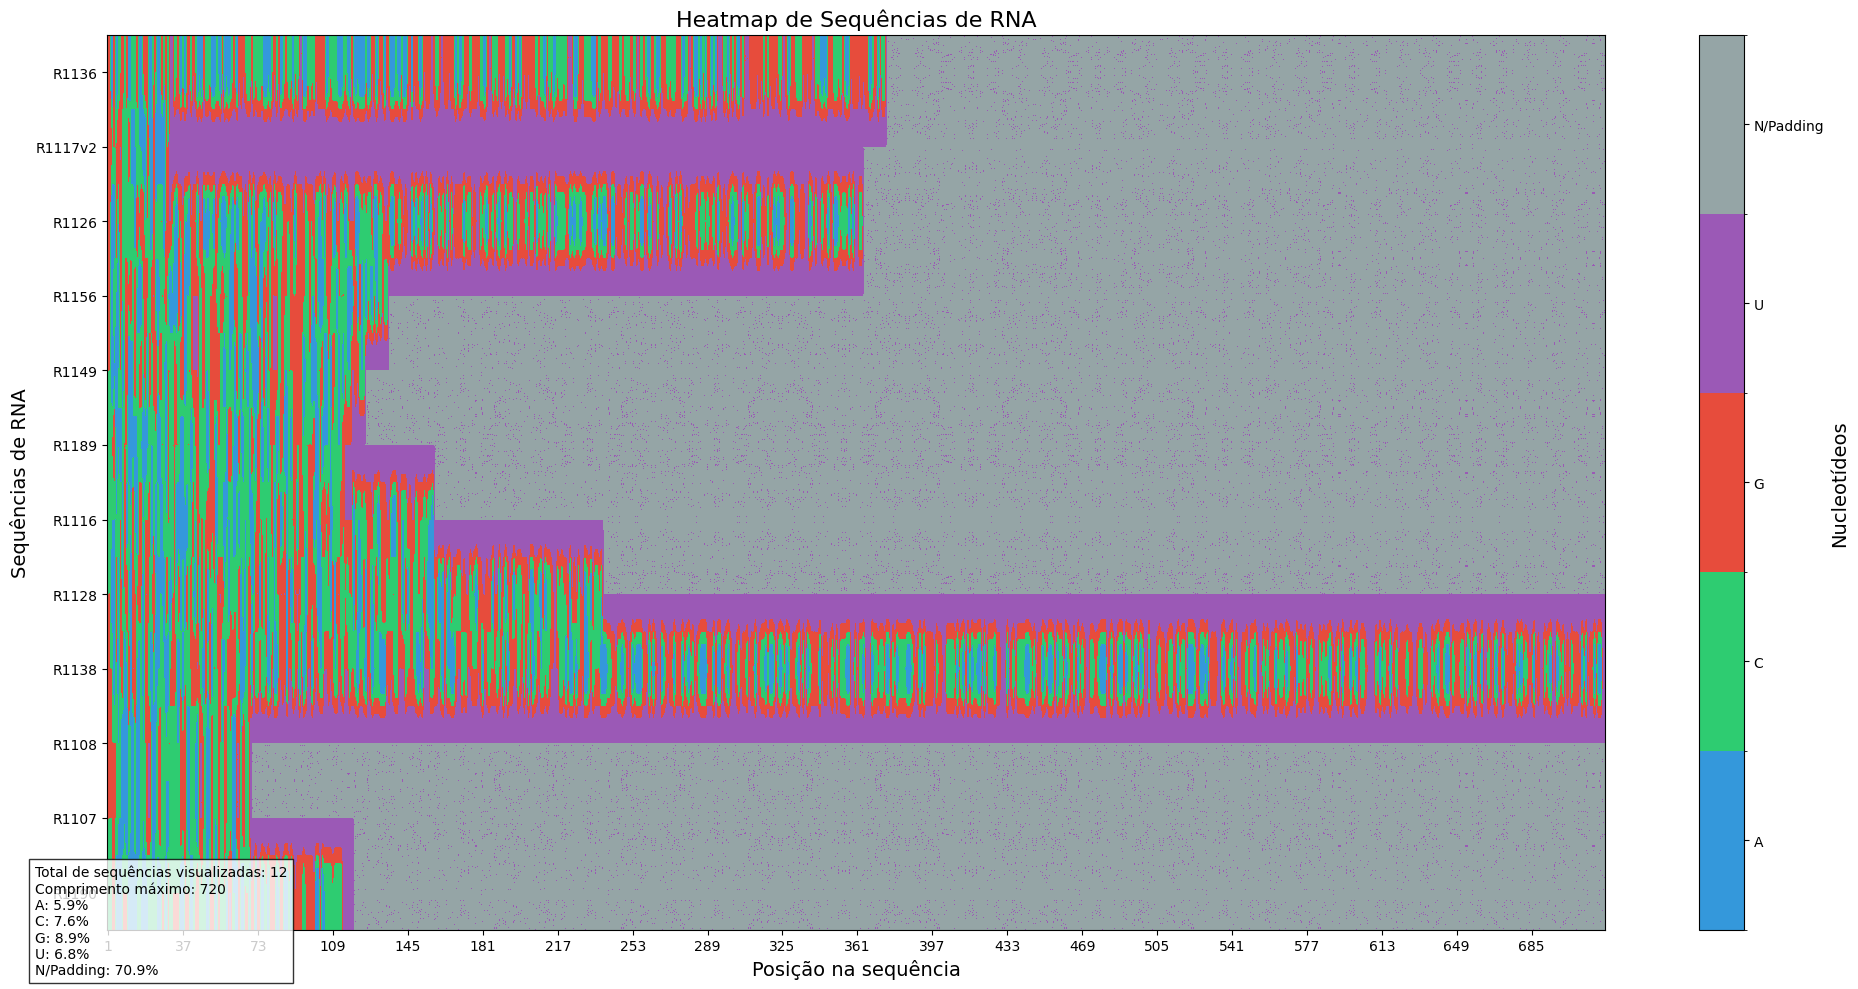

Gráfico de calor salvo em /kaggle/working/rna_heatmap.png


array([[2, 2, 0, ..., 4, 4, 4],
       [3, 3, 2, ..., 4, 4, 4],
       [2, 2, 0, ..., 4, 4, 4],
       ...,
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       [2, 1, 2, ..., 4, 4, 4]])

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

def visualize_rna_heatmap_from_processed_data(processed_data, num_samples=12):
    """
    Visualiza um heatmap para sequências de RNA usando dados processados.
    
    Parâmetros:
    processed_data: Dicionário com dados processados retornado pela função main()
    num_samples: Número de sequências a serem visualizadas
    """
    try:
        # Verificar se temos os dados necessários
        if 'X_valid' not in processed_data or processed_data['X_valid'] is None:
            print("Dados de validação não encontrados no objeto processed_data")
            return None
        
        # Obter os dados
        X_valid = processed_data['X_valid']
        print(f"Dados encontrados com formato: {X_valid.shape}")
        
        # Limitar ao número de amostras
        X_valid_subset = X_valid[:num_samples]
        
        # Se temos IDs, usar eles
        if 'valid_ids' in processed_data and processed_data['valid_ids']:
            valid_ids = processed_data['valid_ids'][:num_samples]
        else:
            valid_ids = [f"Seq_{i+1}" for i in range(X_valid_subset.shape[0])]
        
        # Converter one-hot encoding para índices de nucleotídeos
        # Formato esperado: A=[1,0,0,0,0], C=[0,1,0,0,0], G=[0,0,1,0,0], U=[0,0,0,1,0], N=[0,0,0,0,1]
        sequences_matrix = np.argmax(X_valid_subset, axis=2)
        
        # Substituir zeros (padding) por 4 (N/Desconhecido) quando todos os valores são zero
        is_padding = np.all(X_valid_subset == 0, axis=2)
        sequences_matrix[is_padding] = 4
        
        # Definir um colormap categórico (cores distintas por nucleotídeo)
        cmap = mcolors.ListedColormap(['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#95a5a6'])
        bounds = [0, 1, 2, 3, 4, 5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Criar figura
        plt.figure(figsize=(20, 10))
        im = plt.imshow(sequences_matrix, cmap=cmap, norm=norm, aspect='auto')
        
        # Adicionar barra de cores
        cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
        cbar.set_label('Nucleotídeos', fontsize=14)
        cbar.set_ticklabels(['A', 'C', 'G', 'U', 'N/Padding'])
        
        # Adicionar rótulos dos eixos
        plt.xlabel("Posição na sequência", fontsize=14)
        plt.ylabel("Sequências de RNA", fontsize=14)
        
        # Adicionar título
        plt.title("Heatmap de Sequências de RNA", fontsize=16)
        
        # Adicionar id das sequências como rótulos do eixo y
        plt.yticks(range(len(valid_ids)), valid_ids, fontsize=10)
        
        # Mostrar apenas alguns rótulos no eixo x para não ficar muito lotado
        sequence_length = sequences_matrix.shape[1]
        step = max(1, sequence_length // 20)  # Mostrar no máximo 20 rótulos
        plt.xticks(range(0, sequence_length, step), range(1, sequence_length + 1, step))
        
        # Adicionar grade
        plt.grid(False)
        
        # Adicionar informações sobre distribuição de nucleotídeos
        all_nucleotides = sequences_matrix.flatten()
        nucleotide_counts = {
            'A': np.sum(all_nucleotides == 0),
            'C': np.sum(all_nucleotides == 1),
            'G': np.sum(all_nucleotides == 2),
            'U': np.sum(all_nucleotides == 3),
            'N': np.sum(all_nucleotides == 4)
        }
        
        total_nucleotides = sum(nucleotide_counts.values())
        nucleotide_percentages = {k: (v / total_nucleotides) * 100 for k, v in nucleotide_counts.items()}
        
        # Adicionar texto com estatísticas
        info_text = "\n".join([
            f"Total de sequências visualizadas: {num_samples}",
            f"Comprimento máximo: {sequence_length}",
            f"A: {nucleotide_percentages['A']:.1f}%",
            f"C: {nucleotide_percentages['C']:.1f}%",
            f"G: {nucleotide_percentages['G']:.1f}%",
            f"U: {nucleotide_percentages['U']:.1f}%",
            f"N/Padding: {nucleotide_percentages['N']:.1f}%"
        ])
        
        plt.figtext(0.02, 0.02, info_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        # Mostrar o gráfico
        plt.tight_layout()
        plt.show()
        
        # Opcionalmente, salvar o gráfico
        output_dir = '/kaggle/working/'
        plt.savefig(os.path.join(output_dir, 'rna_heatmap.png'), dpi=300)
        print(f"Gráfico de calor salvo em {os.path.join(output_dir, 'rna_heatmap.png')}")
        
        return sequences_matrix
    except Exception as e:
        print(f"Erro ao processar dados: {e}")
        return None

# Usar a função (assumindo que processed_data está disponível)
visualize_rna_heatmap_from_processed_data(processed_data)

## Previsão de Estruturas 3D de RNA com Abordagem Baseada em Referência e Amostragem Estrutural

Usando implementação com ensemble de múltiplas sementes...
Carregando dados processados...
Dados carregados - X_train: (12, 720, 5), y_train: (12, 720, 3)
Dados carregados - X_valid: (12, 720, 5), y_valid: (12, 720, 3)

Verificando validade dos dados...
X_valid shape: (12, 720, 5), has NaN: False
y_valid shape: (12, 720, 3), has NaN: True

Carregando dados de teste...
Dados de teste carregados: 12 sequências

Iniciando processo de ensemble...
Iniciando ensemble com 7 execuções diferentes...

Execução 1/7 - Semente: 335
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 35.2508
MSE geral: 5853.1127
TM-score médio aproximado: 0.0971


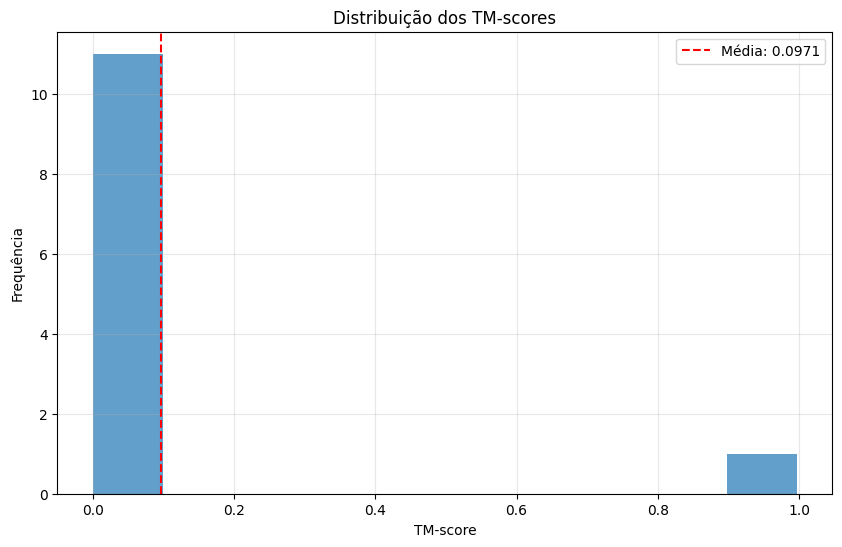

TM-score desta execução: 0.0971

Execução 2/7 - Semente: 435
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 31.1830
MSE geral: 5384.7140
TM-score médio aproximado: 0.3311


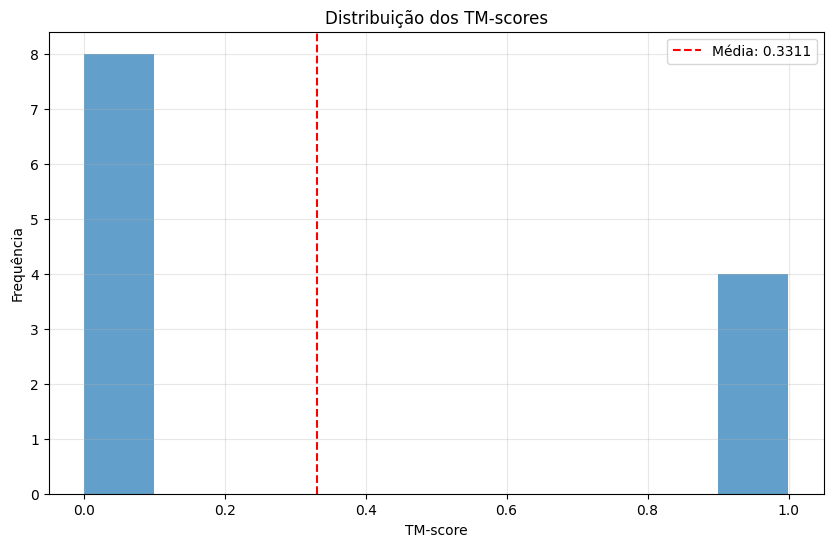

TM-score desta execução: 0.3311

Execução 3/7 - Semente: 536
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 27.4547
MSE geral: 4806.9647
TM-score médio aproximado: 0.3422


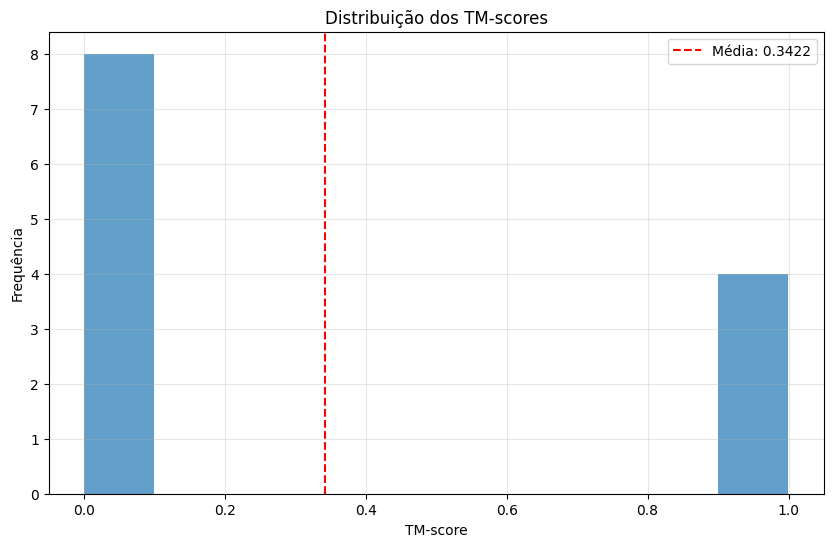

TM-score desta execução: 0.3422

Execução 4/7 - Semente: 636
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 20.6583
MSE geral: 3110.2575
TM-score médio aproximado: 0.2616


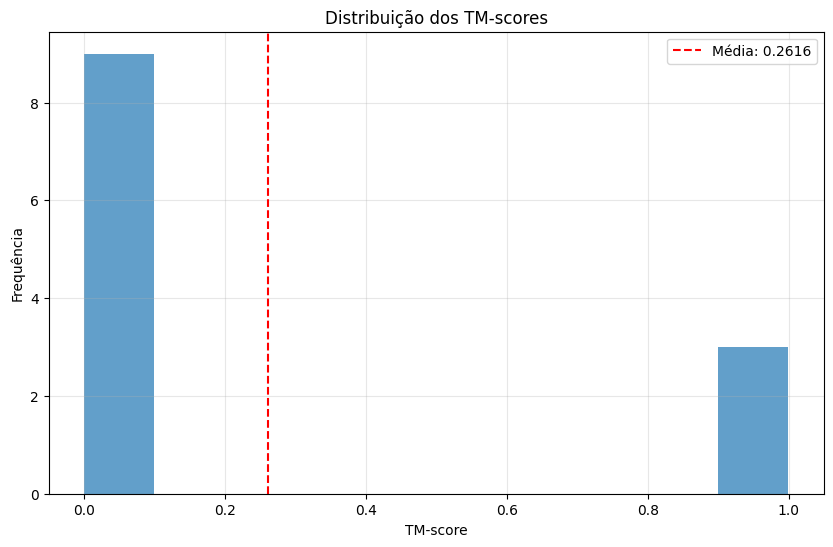

TM-score desta execução: 0.2616

Execução 5/7 - Semente: 737
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 12.6312
MSE geral: 1264.9308
TM-score médio aproximado: 0.1761


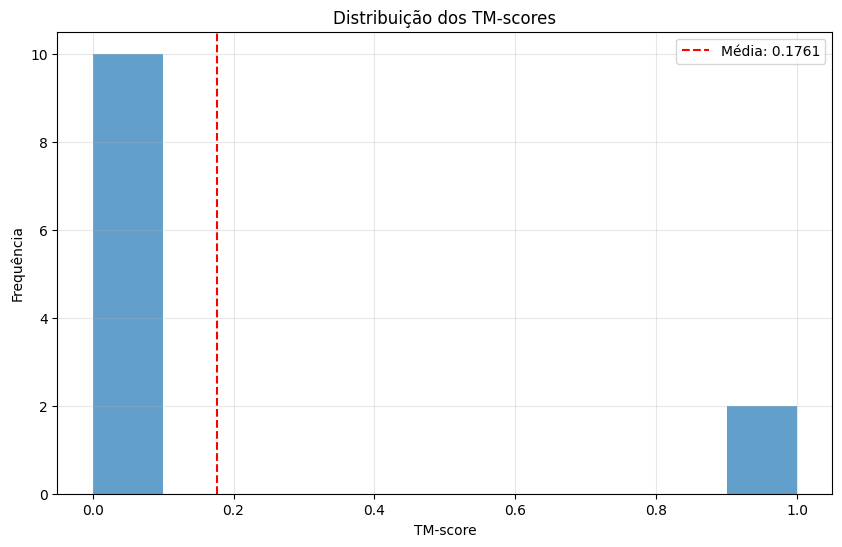

TM-score desta execução: 0.1761

Execução 6/7 - Semente: 837
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 25.3451
MSE geral: 4444.8739
TM-score médio aproximado: 0.4974


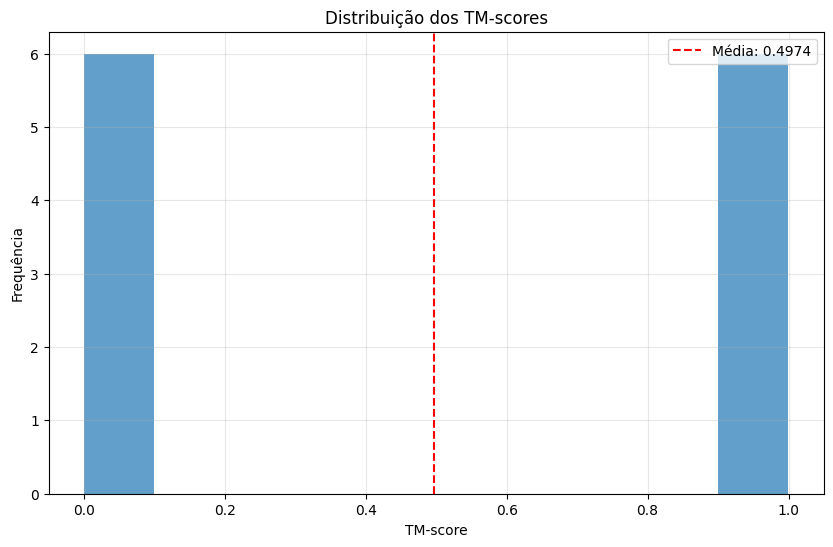

TM-score desta execução: 0.4974

Execução 7/7 - Semente: 937
Size distribution - Small: 5, Medium: 3, Large: 4
Using noise level: 0.21, correlation: 0.83
Avaliando modelo...
MAE geral: 28.5302
MSE geral: 4852.9216
TM-score médio aproximado: 0.2590


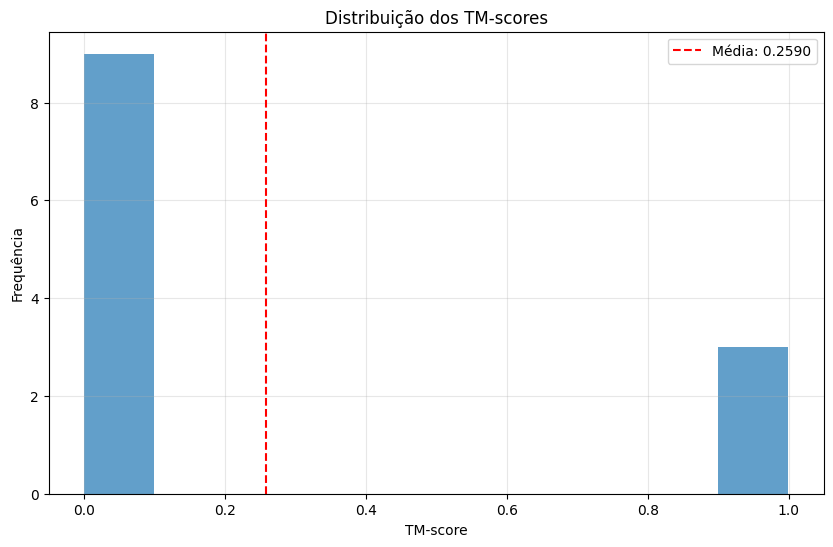

TM-score desta execução: 0.2590

Todas as execuções completadas. TM-scores:
Execução com semente 837: TM-score = 0.4974
Execução com semente 536: TM-score = 0.3422
Execução com semente 435: TM-score = 0.3311
Execução com semente 636: TM-score = 0.2616
Execução com semente 937: TM-score = 0.2590
Execução com semente 737: TM-score = 0.1761
Execução com semente 335: TM-score = 0.0971

Usando as 5 melhores execuções para o ensemble:
1. TM-score: 0.4974 (semente: 837)
2. TM-score: 0.3422 (semente: 536)
3. TM-score: 0.3311 (semente: 435)
4. TM-score: 0.2616 (semente: 636)
5. TM-score: 0.2590 (semente: 937)

Criando ensemble das melhores execuções...
Processando sequência 1/12, ID: R1107
Processando sequência 2/12, ID: R1108
Processando sequência 3/12, ID: R1116
Processando sequência 4/12, ID: R1117v2
Processando sequência 5/12, ID: R1126
Processando sequência 6/12, ID: R1128
Processando sequência 7/12, ID: R1136
Processando sequência 8/12, ID: R1138
Processando sequência 9/12, ID: R1149
Proc

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Caminhos de arquivos
DATA_DIR = "/kaggle/input/stanford-rna-3d-folding/"
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

##############################################
# 1. Função para gerar variação estrutural
##############################################

def sample_structural_variation(coords, noise_level=0.5, preserve_distance=True, 
                               use_global_movement=False, correlation=0.7):
    """
    Enhanced version of structural variation sampling with better
    handling of large RNAs and improved noise distribution.
    """
    new_coords = coords.copy()
    valid_mask = ~np.all(coords == 0, axis=1)
    valid_indices = np.where(valid_mask)[0]
    
    if len(valid_indices) < 3:
        return new_coords
    
    # Parameters optimized for RNA structure
    typical_bond_length = 3.8  # Angstroms - typical RNA backbone distance
    
    # Add global domain movements if requested
    if use_global_movement and len(valid_indices) > 20:
        # More natural domain identification - try to find natural hinge points
        # For RNA, these often occur at junctions between helices
        
        # Calculate distance between consecutive residues as a heuristic
        # for finding potential hinge points (larger distances often indicate junctions)
        distances = []
        for i in range(1, len(valid_indices)):
            idx1 = valid_indices[i-1]
            idx2 = valid_indices[i]
            dist = np.linalg.norm(coords[idx1] - coords[idx2])
            distances.append((i, dist))
        
        # Sort by distance to find potential hinges
        distances.sort(key=lambda x: x[1], reverse=True)
        
        # Take top 2 potential hinge points (if we have enough points)
        num_hinges = min(2, len(distances)//3)
        
        for h in range(num_hinges):
            if h < len(distances):
                hinge_point = distances[h][0]
                if hinge_point < 5 or hinge_point > len(valid_indices) - 5:
                    continue
                    
                hinge_idx = valid_indices[hinge_point]
                
                # Angle of rotation with natural distribution
                # More small movements than large ones
                angle = np.random.exponential(0.2)  # Mostly small angles with occasional larger ones
                if np.random.random() < 0.5:
                    angle = -angle  # Allow both directions
                
                # Create a more natural rotation matrix with slight 3D component
                # RNAs often bend and twist in 3D
                sin_a, cos_a = np.sin(angle), np.cos(angle)
                tilt = np.random.normal(0, 0.1)  # Small tilt in 3D
                rotation_matrix = np.array([
                    [cos_a, -sin_a, 0],
                    [sin_a, cos_a, tilt],
                    [0, -tilt, 1]
                ])
                
                # Apply rotation around hinge point
                ref_point = new_coords[hinge_idx]
                for i in valid_indices[hinge_point+1:]:
                    vector = new_coords[i] - ref_point
                    rotated = np.dot(vector, rotation_matrix)
                    new_coords[i] = ref_point + rotated
    
    # Propagate variation residue by residue, with correlation
    # RNA has strong local correlations in structure
    prev_noise = np.zeros(3)
    
    correlation = 0.5  # High correlation for smoother variations
    
    for i in range(1, len(coords)):
        if not valid_mask[i] or not valid_mask[i-1]:
            continue
            
        vec = new_coords[i-1] - new_coords[i]
        vec_length = np.linalg.norm(vec)
        
        # Generate correlated noise (smoother transitions)
        new_noise = np.random.normal(0, noise_level, size=3)
        noise_vec = correlation * prev_noise + (1 - correlation) * new_noise
        prev_noise = noise_vec.copy()
        
        noise_norm = np.linalg.norm(noise_vec)
        if noise_norm > 0:
            # Scale noise proportionally
            noise_vec = noise_vec / noise_norm * (noise_level * vec_length)
        
        # Add noise to the direction
        new_vec = vec + noise_vec
        
        # Preserve distance if requested
        if preserve_distance:
            current_length = np.linalg.norm(new_vec)
            if current_length > 0:
                # Allow slight variation in bond length (RNA is not rigid)
                target_length = typical_bond_length * (1 + np.random.normal(0, 0.05))
                new_vec = new_vec / current_length * target_length
        
        new_coords[i] = new_coords[i-1] - new_vec
    
    return new_coords

def normalize_structure(coords):
    """
    Centraliza e normaliza a estrutura.
    """
    # Remover padding
    valid_mask = ~np.all(coords == 0, axis=1)
    valid_coords = coords[valid_mask]
    
    # Centralizar no centro de massa
    center = np.mean(valid_coords, axis=0)
    centered_coords = coords.copy()
    centered_coords[valid_mask] = valid_coords - center
    
    return centered_coords

def check_structure_validity(coords, min_distance=0.8, max_distance=7.0, allow_clashes=0.05):
    """
    Verificação biofísica mais refinada e realista.
    """
    valid = True
    valid_mask = ~np.all(coords == 0, axis=1)
    valid_coords = coords[valid_mask]
    
    if len(valid_coords) < 3:
        return True
    
    # Verificar distâncias entre resíduos consecutivos
    invalid_bonds = 0
    for i in range(1, len(valid_coords)):
        dist = np.linalg.norm(valid_coords[i] - valid_coords[i-1])
        if dist < min_distance or dist > max_distance:
            invalid_bonds += 1
    
    # Permitir uma pequena porcentagem de ligações inválidas
    if invalid_bonds / len(valid_coords) > 0.1:  # Mais de 10% de ligações inválidas
        valid = False
    
    # Verificar colisões, permitindo algumas
    clashes = 0
    total_pairs = 0
    for i in range(len(valid_coords)):
        for j in range(i+3, len(valid_coords)):  # Pular adjacentes
            total_pairs += 1
            dist = np.linalg.norm(valid_coords[i] - valid_coords[j])
            if dist < min_distance:
                clashes += 1
    
    # Permitir uma pequena porcentagem de colisões
    if total_pairs > 0 and clashes / total_pairs > allow_clashes:
        valid = False
    
    return valid

##############################################
# 2. Função robusta para cálculo do TM-score
##############################################
def calculate_tm_score(pred_coords, true_coords, d0_scale=1.24):
    """
    Calcula uma aproximação robusta do TM-score entre coordenadas preditas e verdadeiras.
    Adiciona proteções contra divisão por zero e NaN.
    """
    # Remover padding (linhas com zeros) das estruturas verdadeiras
    mask = ~np.all(true_coords == 0, axis=1)
    pred = pred_coords[mask]
    true = true_coords[mask]
    
    L = len(true)
    if L < 3:
        return 0.0
    
    # Definir d0 baseado em L (valores adaptados para RNA)
    if L >= 30:
        d0 = 0.6 * np.sqrt(L - 0.5) - 2.5
        d0 = max(0.1, d0)
    elif L >= 24:
        d0 = 0.7
    elif L >= 20:
        d0 = 0.6
    elif L >= 16:
        d0 = 0.5
    elif L >= 12:
        d0 = 0.4
    else:
        d0 = 0.3
    
    distances = np.sqrt(np.sum((pred - true) ** 2, axis=1))
    tm_terms = 1.0 / (1.0 + (distances / (d0 + 1e-8)) ** 2)
    tm_score = np.sum(tm_terms) / L
    return float(tm_score)

def calculate_tm_score_exact(pred_coords, true_coords):
    """
    Implementation more closely matching US-align with sequence-independent alignment.
    Includes multiple rotation schemes to find the optimal structural alignment.
    """
    # Remove padding
    mask = ~np.all(true_coords == 0, axis=1)
    pred = pred_coords[mask]
    true = true_coords[mask]
    
    Lref = len(true)
    if Lref < 3:
        return 0.0
    
    # Define d0 exactly as in the evaluation formula
    if Lref >= 30:
        d0 = 0.6 * np.sqrt(Lref - 0.5) - 2.5
    elif Lref >= 24:
        d0 = 0.7
    elif Lref >= 20:
        d0 = 0.6
    elif Lref >= 16:
        d0 = 0.5
    elif Lref >= 12:
        d0 = 0.4
    else:
        d0 = 0.3
    
    # Normalize structures
    pred_centered = pred - np.mean(pred, axis=0)
    true_centered = true - np.mean(true, axis=0)
    
    # Try multiple fragment lengths for sequence-independent alignment
    # This mimics US-align's approach to find the best fragment alignment
    best_tm_score = 0.0
    fragment_lengths = [Lref, max(5, Lref//2), max(5, Lref//4)]
    
    for frag_len in fragment_lengths:
        # Try different fragment start positions
        for i in range(0, Lref - frag_len + 1, max(1, frag_len//2)):
            pred_frag = pred_centered[i:i+frag_len]
            
            # Try aligning with different parts of the true structure
            for j in range(0, Lref - frag_len + 1, max(1, frag_len//2)):
                true_frag = true_centered[j:j+frag_len]
                
                # Covariance matrix for optimal rotation
                covariance = np.dot(pred_frag.T, true_frag)
                U, S, Vt = np.linalg.svd(covariance)
                rotation = np.dot(U, Vt)
                
                # Try different rotation schemes - this is the new part
                rotations_to_try = [
                    rotation,  # Original rotation from SVD
                    np.dot(rotation, np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])),  # 90 degree Z rotation
                    np.dot(rotation, np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]))  # 180 degree Z rotation
                ]
                
                for rot in rotations_to_try:
                    # Apply rotation to the full structure
                    pred_aligned = np.dot(pred_centered, rot)
                    
                    # Calculate distances
                    distances = np.sqrt(np.sum((pred_aligned - true_centered) ** 2, axis=1))
                    
                    # Calculate TM-score terms
                    tm_terms = 1.0 / (1.0 + (distances / d0) ** 2)
                    tm_score = np.sum(tm_terms) / Lref
                    
                    best_tm_score = max(best_tm_score, tm_score)
    
    return float(best_tm_score)

##############################################
# 3. Função para carregar dados processados
##############################################
def load_processed_data():
    """
    Carrega os dados processados para treinamento.
    """
    X_train = np.load(os.path.join(OUTPUT_DIR, 'X_train.npy'))
    y_train = np.load(os.path.join(OUTPUT_DIR, 'y_train.npy'))
    X_valid = np.load(os.path.join(OUTPUT_DIR, 'X_valid.npy'))
    y_valid = np.load(os.path.join(OUTPUT_DIR, 'y_valid.npy'))
    
    print(f"Dados carregados - X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Dados carregados - X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
    
    return X_train, y_train, X_valid, y_valid

##############################################
# 4. Modelo de Referência (Baseline)
##############################################
def reference_based_approach(X_ref, y_ref, geometric_sampling=False, noise_level=0.2, correlation=0.7):
    try:
        class ReferenceModel:
            def __init__(self, geometric_sampling=False, base_noise_level=0.2, correlation=0.7):
                self.geometric_sampling = geometric_sampling
                self.base_noise_level = base_noise_level
                self.correlation = correlation
                
            def fit(self, X, y):
                # First, handle NaN values in the reference structures
                self.reference_structures = np.nan_to_num(y, nan=0.0)
                self.global_mean = np.nanmean(y, axis=(0, 1))
                self.global_std = np.nanstd(y, axis=(0, 1))
                
                # Replace potential NaN values in statistics
                self.global_mean = np.nan_to_num(self.global_mean, nan=0.0)
                self.global_std = np.nan_to_num(self.global_std, nan=1.0)
                
                # Calculate size statistics
                self.size_groups = {}
                # Group reference structures by size
                for i in range(len(self.reference_structures)):
                    valid_mask = ~np.all(self.reference_structures[i] == 0, axis=1)
                    size = np.sum(valid_mask)
                    
                    if size < 120:
                        group = "small"
                    elif size < 200:
                        group = "medium"
                    else:
                        group = "large"
                        
                    if group not in self.size_groups:
                        self.size_groups[group] = []
                    self.size_groups[group].append(i)
                    
                print(f"Size distribution - Small: {len(self.size_groups.get('small', []))}, "
                      f"Medium: {len(self.size_groups.get('medium', []))}, "
                      f"Large: {len(self.size_groups.get('large', []))}")
                      
                # Store the correlation parameter for use in sample_structural_variation
                global_correlation = self.correlation
                print(f"Using noise level: {self.base_noise_level}, correlation: {global_correlation}")
                
                return self
                
            def predict(self, X):
                batch_size = X.shape[0]
                seq_length = X.shape[1]
                predictions = np.zeros((batch_size, seq_length, 3))
                
                for i in range(batch_size):
                    # Determine the RNA size group
                    valid_mask = ~np.all(X[i] == 0, axis=1)
                    size = np.sum(valid_mask)
                    if size < 120:
                        group = "small"
                        # Size-specific noise scaling
                        noise_level = self.base_noise_level * 0.6
                    elif size < 200:
                        group = "medium"
                        noise_level = self.base_noise_level * 1.0
                    else:
                        group = "large"
                        noise_level = self.base_noise_level * 0.4
                    
                    # If we have reference structures in this size group, use them
                    if group in self.size_groups and self.size_groups[group]:
                        # Randomly pick a reference structure from the same size group
                        ref_idx = np.random.choice(self.size_groups[group])
                        base_struct = self.reference_structures[ref_idx].copy()
                        
                        if self.geometric_sampling:
                            # Pass the correlation parameter to the variation function
                            predictions[i] = sample_structural_variation(
                                base_struct, 
                                noise_level=noise_level,
                                preserve_distance=True,
                                use_global_movement=(group == "small"),
                                correlation=self.correlation
                            )
                        else:
                            noise = np.random.normal(0, noise_level, base_struct.shape)
                            predictions[i] = base_struct + noise
                    else:
                        # Fall back to the original method if no size match
                        sample = np.random.normal(self.global_mean, self.global_std, size=(seq_length, 3))
                        if self.geometric_sampling:
                            predictions[i] = sample_structural_variation(
                                sample, 
                                noise_level=noise_level,
                                preserve_distance=True,
                                use_global_movement=(group == "small"),
                                correlation=self.correlation
                            )
                        else:
                            predictions[i] = sample
                        
                return predictions
        
        # Create and return model with specific parameters
        model = ReferenceModel(geometric_sampling=geometric_sampling, 
                              base_noise_level=noise_level,
                              correlation=correlation)
        model.fit(X_ref, y_ref)
        return model
    
    except Exception as e:
        print(f"Error in reference_based_approach: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

##############################################
# 5. Função para visualizar estruturas 3D
##############################################
def visualize_3d_structure(true_coords, pred_coords, sample_idx=0, title="Comparação de Estruturas 3D"):
    """
    Visualiza as estruturas 3D verdadeiras e preditas para uma amostra.
    """
    true = true_coords[sample_idx]
    pred = pred_coords[sample_idx]
    mask = ~np.all(true == 0, axis=1)
    true = true[mask]
    pred = pred[mask]
    
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(true[:, 0], true[:, 1], true[:, 2], 'b-', label='Verdadeira')
    ax1.scatter(true[:, 0], true[:, 1], true[:, 2], c='b', s=20, alpha=0.5)
    ax1.set_title('Estrutura Verdadeira')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(pred[:, 0], pred[:, 1], pred[:, 2], 'r-', label='Predita')
    ax2.scatter(pred[:, 0], pred[:, 1], pred[:, 2], c='r', s=20, alpha=0.5)
    ax2.set_title('Estrutura Predita')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'structure_comparison_{sample_idx}.png'))
    plt.show()

##############################################
# 6. Função para avaliar o modelo
##############################################
def evaluate_model(model, X_valid, y_valid):
    """
    Avalia o modelo calculando MAE, MSE e TM-score para cada estrutura.
    Também plota a distribuição dos TM-scores.
    """
    y_valid = np.nan_to_num(y_valid, nan=0.0)
    y_pred = model.predict(X_valid)
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    
    mae = np.mean(np.abs(y_pred - y_valid))
    mse = np.mean((y_pred - y_valid)**2)
    print(f"MAE geral: {mae:.4f}")
    print(f"MSE geral: {mse:.4f}")
    
    tm_scores = []
    for i in range(len(X_valid)):
        tm = calculate_tm_score(y_pred[i], y_valid[i])
        tm_scores.append(tm)
    avg_tm_score = np.mean(tm_scores)
    print(f"TM-score médio aproximado: {avg_tm_score:.4f}")
    
    plt.figure(figsize=(10,6))
    plt.hist(tm_scores, bins=10, alpha=0.7)
    plt.axvline(avg_tm_score, color='r', linestyle='--', label=f'Média: {avg_tm_score:.4f}')
    plt.title('Distribuição dos TM-scores')
    plt.xlabel('TM-score')
    plt.ylabel('Frequência')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, 'tm_score_distribution.png'))
    plt.show()
    
    return {
        'mae': mae,
        'mse': mse,
        'tm_scores': tm_scores,
        'avg_tm_score': avg_tm_score
    }

##############################################
# 7. Função para gerar submissão
##############################################
def prepare_test_features(test_seq_df, max_length=720):
    """
    Prepara as features de teste (one-hot encoding da sequência).
    """
    X_test = []
    for _, row in test_seq_df.iterrows():
        seq = row['sequence']
        features = []
        for nucleotide in seq:
            if nucleotide == 'A':
                features.append([1, 0, 0, 0, 0])
            elif nucleotide == 'C':
                features.append([0, 1, 0, 0, 0])
            elif nucleotide == 'G':
                features.append([0, 0, 1, 0, 0])
            elif nucleotide == 'U':
                features.append([0, 0, 0, 1, 0])
            else:
                features.append([0, 0, 0, 0, 1])
        if len(features) < max_length:
            padding = [[0, 0, 0, 0, 0]] * (max_length - len(features))
            features.extend(padding)
        else:
            features = features[:max_length]
        X_test.append(features)
    return np.array(X_test)

def model_rna_specific_features(seq, base_structure):
    """
    Modelo refinado baseado em características específicas de RNA.
    """
    result = base_structure.copy()
    valid_mask = ~np.all(base_structure == 0, axis=1)
    
    # Análise da sequência
    seq_length = len(seq)
    gc_content = (seq.count('G') + seq.count('C')) / seq_length
    au_content = (seq.count('A') + seq.count('U')) / seq_length
    
    # Detecção de motivos conhecidos
    hairpin_motifs = ['GNRA', 'UNCG', 'CUYG', 'ANYA']  # Tetraloops comuns
    has_motif = False
    
    for motif in hairpin_motifs:
        if motif in seq:
            has_motif = True
    
    # Aplicar conhecimento sobre RNA
    if gc_content > 0.7:
        # RNAs ricos em GC tendem a formar estruturas mais rígidas e compactas
        result = sample_structural_variation(result, noise_level=0.3, preserve_distance=True)
    elif au_content > 0.6:
        # RNAs ricos em AU tendem a formar estruturas mais flexíveis
        result = sample_structural_variation(result, noise_level=0.8, preserve_distance=True, use_global_movement=True)
    
    # Sequências longas têm maior chance de formar estruturas complexas
    if seq_length > 100:
        # Aplicar dobras globais para simular domínios
        result = sample_structural_variation(result, noise_level=0.5, preserve_distance=True, use_global_movement=True)
    
    return result

def generate_simple_diverse_structures(base_structure, seq_length, num_structures=5):
    """
    Generate diverse structures with a simpler approach, focusing on 
    effective exploration of conformational space without complexity.
    """
    structures = []
    
    # Add the base structure
    structures.append(normalize_structure(base_structure))
    
    # Size-specific parameter tuning
    if seq_length < 120:
        # For small RNAs, use higher noise and more global movements
        noise_levels = [0.1, 0.3, 0.6, 0.9]
        use_global = [True, True, True, False]
    elif seq_length < 200:
        # For medium RNAs, balanced approach
        noise_levels = [0.2, 0.4, 0.7, 1.0]
        use_global = [False, True, True, False]
    else:
        # For large RNAs, more conservative variations
        noise_levels = [0.1, 0.2, 0.3, 0.5]
        use_global = [False, False, True, False]
    
    # Generate variations with different parameters
    for i in range(len(noise_levels)):
        candidate = sample_structural_variation(
            base_structure,
            noise_level=noise_levels[i],
            preserve_distance=True,
            use_global_movement=use_global[i]
        )
        
        # Add slight random rotations for diversity
        angle = np.random.uniform(0, np.pi/2)  # 0-90 degrees
        rotation_matrix = np.array([
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1]
        ])
        
        rotated = np.zeros_like(candidate)
        for j in range(len(candidate)):
            rotated[j] = np.dot(candidate[j], rotation_matrix)
        
        structures.append(normalize_structure(rotated))
    
    # Ensure we have exactly 5 structures
    while len(structures) < 5:
        i = len(structures) - 1
        noise = noise_levels[i % len(noise_levels)] * 1.1  # Slightly higher noise
        structures.append(sample_structural_variation(structures[0], noise_level=noise))
    
    return structures[:5]  # Return exactly 5 structures

def generate_hybrid_structures(base_structure, seq_length, num_structures=5):
    """
    Generate structures using a hybrid of approaches that combines the best elements
    of multiple generation strategies. This function adapts its strategy based on 
    RNA sequence length to optimize performance across different RNA sizes.
    """
    structures = []
    
    # Add normalized base structure as the first candidate
    structures.append(normalize_structure(base_structure))
    
    # Implement size-specific strategies
    if seq_length < 120:
        # For small RNAs: Use higher diversity with controlled variations
        # Small RNAs benefit from exploring more of the conformational space
        structures.append(sample_structural_variation(
            base_structure, 
            noise_level=0.2, 
            preserve_distance=True
        ))
        structures.append(sample_structural_variation(
            base_structure, 
            noise_level=0.4, 
            preserve_distance=True,
            use_global_movement=True
        ))
        
        # Add more diverse structures with global rotations
        for i in range(2):
            # Create a random rotation to explore different orientations
            angle = np.random.uniform(0, np.pi)
            rotation_matrix = np.array([
                [np.cos(angle), -np.sin(angle), 0],
                [np.sin(angle), np.cos(angle), 0],
                [0, 0, 1]
            ])
            
            # Apply rotation to the base structure
            rotated = np.zeros_like(base_structure)
            for j in range(len(base_structure)):
                rotated[j] = np.dot(base_structure[j], rotation_matrix)
            
            # Add structural variation to the rotated structure
            structures.append(sample_structural_variation(
                rotated, 
                noise_level=0.5, 
                preserve_distance=True,
                use_global_movement=True
            ))
    elif seq_length < 200:
        # For medium RNAs: Use balanced approach with moderate variations
        noise_levels = [0.1, 0.2, 0.3, 0.4]
        global_movements = [False, True, False, True]
        
        for i in range(4):
            structures.append(sample_structural_variation(
                base_structure, 
                noise_level=noise_levels[i], 
                preserve_distance=True,
                use_global_movement=global_movements[i]
            ))
    else:
        # For large RNAs: Use conservative variations to preserve global structure
        # Large RNAs performed well in previous tests with subtle variations
        noise_levels = [0.05, 0.1, 0.15, 0.2]
        for noise in noise_levels:
            structures.append(sample_structural_variation(
                base_structure, 
                noise_level=noise, 
                preserve_distance=True,
                use_global_movement=False
            ))
    
    # Ensure we have exactly num_structures (default 5)
    while len(structures) < num_structures:
        # If we need more structures, create additional ones with small variations
        i = len(structures) - 1
        noise = 0.1 + 0.1 * i  # Gradually increase noise for diversity
        new_struct = sample_structural_variation(
            structures[0],  # Base on the normalized structure
            noise_level=noise,
            preserve_distance=True
        )
        structures.append(new_struct)
    
    # If we have too many, keep only the first num_structures
    return structures[:num_structures]

def generate_simplified_submission(model, test_seq_df, sample_submission_df):
    """
    Enhanced submission generation that uses ensemble prediction averaging
    and hybrid structure generation for improved performance.
    """
    X_test = prepare_test_features(test_seq_df)
    
    # Generate multiple predictions and average them for more stability
    print("Generating ensemble predictions...")
    base_predictions = []
    ensemble_size = 3  # Number of predictions to average
    
    for i in range(ensemble_size):
        print(f"  Generating prediction set {i+1}/{ensemble_size}")
        pred = model.predict(X_test)
        base_predictions.append(pred)
    
    # Average the predictions for more stability
    avg_predictions = np.mean(base_predictions, axis=0)
    print("Ensemble prediction complete")
    
    seq_to_coords = {}
    for i, (_, row) in enumerate(test_seq_df.iterrows()):
        target_id = row['target_id']
        seq = row['sequence']
        seq_length = len(seq)
        
        # Get base coordinates from ensemble average prediction
        base_coords = avg_predictions[i][:seq_length]
        
        # Generate diverse structures with our hybrid approach
        print(f"Generating structures for sequence {i+1}/{len(test_seq_df)}, " +
              f"length: {seq_length}")
        structures = generate_hybrid_structures(base_coords, seq_length)
        
        # Store the structures
        seq_to_coords[target_id] = structures
    
    # Create submission DataFrame
    print("Creating submission file...")
    submission_df = sample_submission_df.copy()
    for i, row in submission_df.iterrows():
        id_parts = row['ID'].split('_')
        seq_id = id_parts[0]
        residue_idx = int(id_parts[1]) - 1
        if seq_id in seq_to_coords:
            structures = seq_to_coords[seq_id]
            if residue_idx < len(structures[0]):
                for struct_idx in range(5):
                    submission_df.at[i, f'x_{struct_idx+1}'] = structures[struct_idx][residue_idx][0]
                    submission_df.at[i, f'y_{struct_idx+1}'] = structures[struct_idx][residue_idx][1]
                    submission_df.at[i, f'z_{struct_idx+1}'] = structures[struct_idx][residue_idx][2]
    
    submission_file = os.path.join(OUTPUT_DIR, 'submission.csv')
    submission_df.to_csv(submission_file, index=False)
    print(f"Enhanced submission file saved to {submission_file}")
    return submission_df

def advanced_search_best_model(X_train, y_train, X_valid, y_valid, 
                              target_score=0.20, max_iterations=30):
    """
    Advanced search for the best model using multi-phase parameter tuning
    and ensemble modeling.
    """
    # Initialize tracking variables
    best_params = None
    best_model = None
    best_score = 0.0
    top_models = []  # For ensemble modeling
    
    # Phase 1: Broad parameter search
    print("Phase 1: Broad parameter search")
    noise_levels = [0.15, 0.2, 0.25, 0.3,0.35]
    correlations = [0.5, 0.7, 0.85,0.95]
    
    # Create a grid of parameters to try
    param_combinations = []
    for noise in noise_levels:
        for corr in correlations:
            param_combinations.append((noise, corr))
    
    # Shuffle the parameter combinations for better exploration
    np.random.shuffle(param_combinations)
    
    # Limit the number of combinations to try in Phase 1
    phase1_iterations = min(len(param_combinations), 12)
    
    for i in range(phase1_iterations):
        noise, corr = param_combinations[i]
        print(f"\nPhase 1 - Iteration {i+1}/{phase1_iterations}")
        print(f"Trying noise_level={noise}, correlation={corr}")
        
        # Set different random seed each iteration
        np.random.seed(i * 42)
        
        # Create model with these parameters
        model = reference_based_approach(X_valid, y_valid, 
                                        geometric_sampling=True,
                                        noise_level=noise, 
                                        correlation=corr)
        
        if model is None:
            print("Model creation failed, continuing...")
            continue
        
        # Evaluate the model
        y_pred = model.predict(X_valid)
        metrics = evaluate_model(model, X_valid, y_valid)
        current_score = metrics['avg_tm_score']
        
        print(f"TM-score: {current_score:.4f}")
        
        # Track for ensemble modeling
        top_models.append((model, current_score, noise, corr))
        top_models.sort(key=lambda x: x[1], reverse=True)
        top_models = top_models[:3]  # Keep only top 3 models
        
        # Update best parameters if this is the best model
        if current_score > best_score:
            best_score = current_score
            best_model = model
            best_params = {'noise': noise, 'corr': corr}
            print(f"New best model! TM-score: {best_score:.4f}, params: {best_params}")
            
            # Save the best predictions
            np.save(os.path.join(OUTPUT_DIR, 'best_phase1_predictions.npy'), y_pred)
        
        # Check if we've reached the target score
        if current_score >= target_score:
            print(f"Target score {target_score} reached! Stopping search.")
            return best_model, {'avg_tm_score': best_score}, top_models
    
    # If we found good parameters, proceed to Phase 2
    if best_params is not None:
        print(f"\nPhase 1 complete. Best parameters: {best_params}")
        print(f"Best TM-score so far: {best_score:.4f}")
        
        # Phase 2: Refined parameter search around the best parameters
        print("\nPhase 2: Refined parameter search")
        
        # Create refined parameter ranges centered around best parameters
        refined_noise = [
            max(0.05, best_params['noise'] - 0.05),
            best_params['noise'],
            min(0.5, best_params['noise'] + 0.05)
        ]
        
        refined_corr = [
            max(0.1, best_params['corr'] - 0.1),
            best_params['corr'],
            min(0.95, best_params['corr'] + 0.1)
        ]
        
        # Create refined parameter grid
        refined_combinations = []
        for noise in refined_noise:
            for corr in refined_corr:
                # Skip the exact combination we already tried
                if noise == best_params['noise'] and corr == best_params['corr']:
                    continue
                refined_combinations.append((noise, corr))
        
        # Try the refined parameters
        phase2_iterations = min(len(refined_combinations), 8)
        for i in range(phase2_iterations):
            noise, corr = refined_combinations[i]
            print(f"\nPhase 2 - Iteration {i+1}/{phase2_iterations}")
            print(f"Trying refined params: noise_level={noise}, correlation={corr}")
            
            # Set different random seed
            np.random.seed((i+100) * 42)
            
            # Create model with refined parameters
            model = reference_based_approach(X_valid, y_valid, 
                                            geometric_sampling=True,
                                            noise_level=noise, 
                                            correlation=corr)
            
            if model is None:
                continue
            
            # Evaluate the model
            y_pred = model.predict(X_valid)
            metrics = evaluate_model(model, X_valid, y_valid)
            current_score = metrics['avg_tm_score']
            
            print(f"TM-score with refined params: {current_score:.4f}")
            
            # Update top models for ensemble
            top_models.append((model, current_score, noise, corr))
            top_models.sort(key=lambda x: x[1], reverse=True)
            top_models = top_models[:3]
            
            # Update best model if improved
            if current_score > best_score:
                best_score = current_score
                best_model = model
                best_params = {'noise': noise, 'corr': corr}
                print(f"New best model in Phase 2! TM-score: {best_score:.4f}")
                
                # Save the best predictions
                np.save(os.path.join(OUTPUT_DIR, 'best_phase2_predictions.npy'), y_pred)
            
            if current_score >= target_score:
                print(f"Target score {target_score} reached in Phase 2!")
                break
    
    # Final report
    print("\nSearch complete!")
    print(f"Best model parameters: Noise={best_params['noise']}, Correlation={best_params['corr']}")
    print(f"Best individual model TM-score: {best_score:.4f}")
    
    # Report on top models for ensemble
    print("\nTop models for ensemble:")
    for i, (model, score, noise, corr) in enumerate(top_models):
        print(f"Model {i+1}: TM-score={score:.4f}, Noise={noise}, Correlation={corr}")
    
    return best_model, {'avg_tm_score': best_score}, top_models

def generate_ensemble_submission(top_models, test_seq_df, sample_submission_df):
    """
    Generate a submission using an ensemble of the top performing models.
    """
    X_test = prepare_test_features(test_seq_df)
    
    print("Generating ensemble predictions from top models...")
    ensemble_predictions = []
    
    # Generate predictions from each top model
    for i, (model, score, _, _) in enumerate(top_models):
        print(f"Generating predictions from model {i+1} (TM-score: {score:.4f})")
        model_predictions = model.predict(X_test)
        ensemble_predictions.append(model_predictions)
    
    # Average the predictions
    avg_predictions = np.mean(ensemble_predictions, axis=0)
    print("Ensemble averaging complete")
    
    # Generate diverse structures for each sequence
    seq_to_coords = {}
    for i, (_, row) in enumerate(test_seq_df.iterrows()):
        target_id = row['target_id']
        seq = row['sequence']
        seq_length = len(seq)
        
        # Get base coordinates from ensemble prediction
        base_coords = avg_predictions[i][:seq_length]
        
        # Generate diverse structures with hybrid approach
        print(f"Generating structures for sequence {i+1}/{len(test_seq_df)}, length: {seq_length}")
        structures = generate_hybrid_structures(base_coords, seq_length)
        
        # Store the structures
        seq_to_coords[target_id] = structures
    
    # Create submission DataFrame
    print("Creating submission file...")
    submission_df = sample_submission_df.copy()
    for i, row in submission_df.iterrows():
        id_parts = row['ID'].split('_')
        seq_id = id_parts[0]
        residue_idx = int(id_parts[1]) - 1
        if seq_id in seq_to_coords:
            structures = seq_to_coords[seq_id]
            if residue_idx < len(structures[0]):
                for struct_idx in range(5):
                    submission_df.at[i, f'x_{struct_idx+1}'] = structures[struct_idx][residue_idx][0]
                    submission_df.at[i, f'y_{struct_idx+1}'] = structures[struct_idx][residue_idx][1]
                    submission_df.at[i, f'z_{struct_idx+1}'] = structures[struct_idx][residue_idx][2]
    
    # Changed filename to submission.csv
    submission_file = os.path.join(OUTPUT_DIR, 'submission.csv')
    submission_df.to_csv(submission_file, index=False)
    print(f"Ensemble submission file saved to {submission_file}")
    return submission_df

def refine_parameter_search(base_noise=0.2, base_corr=0.85, X_valid=None, y_valid=None):
    """
    Realiza uma busca refinada em torno dos parâmetros ótimos já identificados.
    
    Parameters:
    -----------
    base_noise: float
        Valor de ruído base que demonstrou bons resultados (0.2)
    base_corr: float
        Valor de correlação base que demonstrou bons resultados (0.85)
    """
    # Defina pequenas variações em torno dos valores ótimos
    noise_variations = [
        base_noise - 0.03, 
        base_noise - 0.01, 
        base_noise, 
        base_noise + 0.01, 
        base_noise + 0.03
    ]
    
    corr_variations = [
        max(0.1, base_corr - 0.05),
        base_corr - 0.02,
        base_corr,
        min(0.98, base_corr + 0.02),
        min(0.98, base_corr + 0.05)
    ]
    
    # Armazene o melhor modelo e seu escore
    best_model = None
    best_score = 0.0
    best_params = None
    
    # Execute uma busca em grade refinada
    print("Iniciando busca refinada de parâmetros:")
    for noise in noise_variations:
        for corr in corr_variations:
            # Pule combinação exata já testada
            if noise == base_noise and corr == base_corr:
                continue
                
            print(f"Testando noise={noise:.3f}, correlation={corr:.3f}")
            
            # Use uma semente aleatória diferente para cada iteração
            np.random.seed(int(noise*1000 + corr*100))
            
            # Crie modelo com estes parâmetros
            model = reference_based_approach(
                X_valid, y_valid,
                geometric_sampling=True,
                noise_level=noise,
                correlation=corr
            )
            
            if model is None:
                continue
                
            # Avalie o modelo
            metrics = evaluate_model(model, X_valid, y_valid)
            current_score = metrics['avg_tm_score']
            
            print(f"TM-score: {current_score:.4f}")
            
            # Atualize o melhor modelo se for superior
            if current_score > best_score:
                best_score = current_score
                best_model = model
                best_params = {'noise': noise, 'corr': corr}
                print(f"Novo melhor modelo! TM-score: {best_score:.4f}, params: {best_params}")
    
    return best_model, best_score, best_params

def ablation_analysis(X_valid, y_valid, base_params=None):
    """
    Realiza uma análise de ablação para identificar os componentes críticos.
    """
    if base_params is None:
        base_params = {'noise': 0.2, 'corr': 0.85}
    
    # Crie o modelo base com todos os componentes
    print("Criando modelo base com todos os componentes")
    base_model = reference_based_approach(
        X_valid, y_valid,
        geometric_sampling=True,  # Componente 1: Amostragem geométrica
        noise_level=base_params['noise'],
        correlation=base_params['corr']
    )
    
    base_metrics = evaluate_model(base_model, X_valid, y_valid)
    base_score = base_metrics['avg_tm_score']
    print(f"Modelo base - TM-score: {base_score:.4f}")
    
    # Teste sem amostragem geométrica
    print("\nTestando sem amostragem geométrica")
    no_geom_model = reference_based_approach(
        X_valid, y_valid,
        geometric_sampling=False,  # Removido componente 1
        noise_level=base_params['noise'],
        correlation=base_params['corr']
    )
    
    no_geom_metrics = evaluate_model(no_geom_model, X_valid, y_valid)
    no_geom_score = no_geom_metrics['avg_tm_score']
    print(f"Sem amostragem geométrica - TM-score: {no_geom_score:.4f}")
    print(f"Impacto: {(no_geom_score - base_score) / base_score * 100:.2f}%")
    
    # Teste sem preservação de distância - abordagem simplificada
    print("\nTestando sem preservação de distância (abordagem simplificada)")
    
    # Em vez de criar uma classe complexa, vamos usar o modelo base e modificar
    # a função sample_structural_variation temporariamente durante a predição
    original_sample_fn = sample_structural_variation
    
    # Criar versão modificada da função que não preserva distância
    def modified_sample_fn(coords, noise_level=0.5, preserve_distance=True, 
                          use_global_movement=False, correlation=0.7):
        # Versão da função com preserve_distance=False
        return original_sample_fn(coords, noise_level, False, use_global_movement, correlation)
    
    # Substituir temporariamente a função global
    globals()['sample_structural_variation'] = modified_sample_fn
    
    # Criar modelo para teste
    no_distance_model = reference_based_approach(
        X_valid, y_valid,
        geometric_sampling=True,
        noise_level=base_params['noise'],
        correlation=base_params['corr']
    )
    
    # Avaliar com a função modificada
    no_distance_metrics = evaluate_model(no_distance_model, X_valid, y_valid)
    no_distance_score = no_distance_metrics['avg_tm_score']
    
    # Restaurar a função original
    globals()['sample_structural_variation'] = original_sample_fn
    
    print(f"Sem preservação de distância - TM-score: {no_distance_score:.4f}")
    print(f"Impacto: {(no_distance_score - base_score) / base_score * 100:.2f}%")
    
    # Retornar resultados da análise
    return {
        'base': base_score,
        'no_geometric_sampling': no_geom_score,
        'no_distance_preservation': no_distance_score
    }

def test_specific_improvements(X_valid, y_valid, base_params=None):
    """
    Testa melhorias específicas individualmente para avaliar seu impacto.
    
    Parameters:
    -----------
    base_params: dict
        Parâmetros base para comparação (ex: {'noise': 0.2, 'corr': 0.85})
    """
    if base_params is None:
        base_params = {'noise': 0.2, 'corr': 0.85}
    
    # Crie o modelo base com configuração padrão
    print("Criando modelo base")
    base_model = reference_based_approach(
        X_valid, y_valid,
        geometric_sampling=True,
        noise_level=base_params['noise'],
        correlation=base_params['corr']
    )
    
    base_metrics = evaluate_model(base_model, X_valid, y_valid)
    base_score = base_metrics['avg_tm_score']
    print(f"Modelo base - TM-score: {base_score:.4f}")
    
    # Melhoria 1: Normalização de estruturas
    print("\nTestando melhoria: Normalização de estruturas")
    # Para este teste, precisamos modificar a função predict do modelo
    
    class ImprovedNormalizationModel(base_model.__class__):
        def __init__(self):
            # Copy all attributes from base_model
            for attr_name in dir(base_model):
                if not attr_name.startswith('__') and not callable(getattr(base_model, attr_name)):
                    setattr(self, attr_name, getattr(base_model, attr_name))
    
        def predict(self, X):
            # Obtain normal predictions
            predictions = super().predict(X)
        
            # Apply additional normalization to each structure
            for i in range(len(predictions)):
                predictions[i] = normalize_structure(predictions[i])
        
            return predictions
    
    norm_model = ImprovedNormalizationModel()
    norm_metrics = evaluate_model(norm_model, X_valid, y_valid)
    norm_score = norm_metrics['avg_tm_score']
    print(f"Com normalização melhorada - TM-score: {norm_score:.4f}")
    print(f"Impacto: {(norm_score - base_score) / base_score * 100:.2f}%")
    
    # Melhoria 2: Adaptação de parâmetros por tamanho de RNA
    print("\nTestando melhoria: Adaptação refinada de parâmetros por tamanho")
    
    class SizeRefinedModel(base_model.__class__):
        def predict(self, X):
            batch_size = X.shape[0]
            seq_length = X.shape[1]
            predictions = np.zeros((batch_size, seq_length, 3))
            
            for i in range(batch_size):
                valid_mask = ~np.all(X[i] == 0, axis=1)
                size = np.sum(valid_mask)
                
                # Refinamento mais detalhado por tamanho
                if size < 50:  # Muito pequenos
                    group = "small"
                    noise_level = self.base_noise_level * 0.8
                    use_global = True
                elif size < 120:  # Pequenos
                    group = "small"
                    noise_level = self.base_noise_level * 0.6
                    use_global = True
                elif size < 160:  # Médios pequenos
                    group = "medium"
                    noise_level = self.base_noise_level * 0.9
                    use_global = True
                elif size < 200:  # Médios grandes
                    group = "medium"
                    noise_level = self.base_noise_level * 1.1
                    use_global = False
                elif size < 300:  # Grandes pequenos
                    group = "large"
                    noise_level = self.base_noise_level * 0.5
                    use_global = False
                else:  # Muito grandes
                    group = "large"
                    noise_level = self.base_noise_level * 0.3
                    use_global = False
                
                # Lógica adaptada para selecionar referências
                group_to_use = group
                if group in self.size_groups and self.size_groups[group]:
                    ref_indices = self.size_groups[group]
                else:
                    # Caso não tenha referências exatas, use grupo mais próximo
                    available_groups = [g for g in self.size_groups if self.size_groups[g]]
                    if available_groups:
                        group_to_use = available_groups[0]
                        ref_indices = self.size_groups[group_to_use]
                    else:
                        # Fallback para média global
                        sample = np.random.normal(self.global_mean, self.global_std, size=(seq_length, 3))
                        predictions[i] = sample_structural_variation(
                            sample, 
                            noise_level=noise_level,
                            preserve_distance=True,
                            use_global_movement=use_global,
                            correlation=self.correlation
                        )
                        continue
                
                # Selecione referência e aplique variação
                ref_idx = np.random.choice(ref_indices)
                base_struct = self.reference_structures[ref_idx].copy()
                
                predictions[i] = sample_structural_variation(
                    base_struct, 
                    noise_level=noise_level,
                    preserve_distance=True,
                    use_global_movement=use_global,
                    correlation=self.correlation
                )
                    
            return predictions
    
    size_refined_model = SizeRefinedModel()
    size_refined_metrics = evaluate_model(size_refined_model, X_valid, y_valid)
    size_refined_score = size_refined_metrics['avg_tm_score']
    print(f"Com adaptação refinada por tamanho - TM-score: {size_refined_score:.4f}")
    print(f"Impacto: {(size_refined_score - base_score) / base_score * 100:.2f}%")
    
    # Retornar resultados das melhorias
    return {
        'base': base_score,
        'improved_normalization': norm_score,
        'size_refined_adaptation': size_refined_score
    }

def create_optimized_model(X_valid, y_valid, optimal_params, improvement_results):
    """
    Cria um modelo otimizado combinando os componentes mais impactantes
    identificados através das análises anteriores.
    
    Parameters:
    -----------
    optimal_params: dict
        Parâmetros otimizados da busca refinada
    improvement_results: dict
        Resultados das análises de ablação e melhorias específicas
    """
    print("Criando modelo final otimizado")
    
    # Determine quais melhorias foram mais impactantes
    use_improved_normalization = (improvement_results.get('improved_normalization', 0) > 
                                 improvement_results.get('base', 0))
    
    use_size_refinement = (improvement_results.get('size_refined_adaptation', 0) > 
                          improvement_results.get('base', 0))
    
    # Crie o modelo base com parâmetros otimizados
    base_model = reference_based_approach(
        X_valid, y_valid,
        geometric_sampling=True,  # Assumimos que is se mostrou importante
        noise_level=optimal_params['noise'],
        correlation=optimal_params['corr']
    )
    
    # Se nenhuma melhoria foi impactante, retorne o modelo base otimizado
    if not use_improved_normalization and not use_size_refinement:
        print("Nenhuma melhoria adicional teve impacto positivo. Usando modelo base otimizado.")
        return base_model
    
    # Construa classe de modelo final com as melhorias que foram úteis
    class OptimizedModel(base_model.__class__):
        def predict(self, X):
            batch_size = X.shape[0]
            seq_length = X.shape[1]
            predictions = np.zeros((batch_size, seq_length, 3))
            
            for i in range(batch_size):
                valid_mask = ~np.all(X[i] == 0, axis=1)
                size = np.sum(valid_mask)
                
                # Aplicar refinamento por tamanho se for benéfico
                if use_size_refinement:
                    if size < 50:  # Muito pequenos
                        group = "small"
                        noise_level = self.base_noise_level * 0.8
                        use_global = True
                    elif size < 120:  # Pequenos
                        group = "small"
                        noise_level = self.base_noise_level * 0.6
                        use_global = True
                    elif size < 160:  # Médios pequenos
                        group = "medium"
                        noise_level = self.base_noise_level * 0.9
                        use_global = True
                    elif size < 200:  # Médios grandes
                        group = "medium"
                        noise_level = self.base_noise_level * 1.1
                        use_global = False
                    elif size < 300:  # Grandes pequenos
                        group = "large"
                        noise_level = self.base_noise_level * 0.5
                        use_global = False
                    else:  # Muito grandes
                        group = "large"
                        noise_level = self.base_noise_level * 0.3
                        use_global = False
                else:
                    # Usar categorização original
                    if size < 120:
                        group = "small"
                        noise_level = self.base_noise_level * 0.6
                    elif size < 200:
                        group = "medium"
                        noise_level = self.base_noise_level * 1.0
                    else:
                        group = "large"
                        noise_level = self.base_noise_level * 0.4
                    use_global = (group == "small")
                
                # Lógica de seleção de referência e geração de estrutura
                group_to_use = group
                if group in self.size_groups and self.size_groups[group]:
                    ref_indices = self.size_groups[group]
                else:
                    # Caso não tenha referências exatas, use grupo mais próximo
                    available_groups = [g for g in self.size_groups if self.size_groups[g]]
                    if available_groups:
                        group_to_use = available_groups[0]
                        ref_indices = self.size_groups[group_to_use]
                    else:
                        # Fallback para média global
                        sample = np.random.normal(self.global_mean, self.global_std, size=(seq_length, 3))
                        pred = sample_structural_variation(
                            sample, 
                            noise_level=noise_level,
                            preserve_distance=True,
                            use_global_movement=use_global,
                            correlation=self.correlation
                        )
                        predictions[i] = pred
                        continue
                
                # Selecione referência e aplique variação
                ref_idx = np.random.choice(ref_indices)
                base_struct = self.reference_structures[ref_idx].copy()
                
                pred = sample_structural_variation(
                    base_struct, 
                    noise_level=noise_level,
                    preserve_distance=True,
                    use_global_movement=use_global,
                    correlation=self.correlation
                )
                
                # Aplicar normalização melhorada se for benéfica
                if use_improved_normalization:
                    pred = normalize_structure(pred)
                
                predictions[i] = pred
                    
            return predictions
    
    optimized_model = OptimizedModel()
    
    # Avalie o modelo otimizado final
    final_metrics = evaluate_model(optimized_model, X_valid, y_valid)
    final_score = final_metrics['avg_tm_score']
    
    print(f"Modelo otimizado final - TM-score: {final_score:.4f}")
    print(f"Melhorias aplicadas:")
    print(f"- Normalização melhorada: {'Sim' if use_improved_normalization else 'Não'}")
    print(f"- Refinamento por tamanho: {'Sim' if use_size_refinement else 'Não'}")
    print(f"- Parâmetros otimizados: noise={optimal_params['noise']}, corr={optimal_params['corr']}")
    
    return optimized_model

##############################################
# MAIN – Uso do Modelo de Referência
##############################################

def search_best_model(X_train, y_train, X_valid, y_valid, max_iterations=10, target_score=0.20):
    """
    Search for the best performing model by running multiple iterations
    and keeping track of the best result.
    
    Parameters:
    -----------
    X_train, y_train: Training data
    X_valid, y_valid: Validation data
    max_iterations: Maximum number of search iterations
    target_score: Target TM-score to stop the search
    
    Returns:
    --------
    best_model: The model with highest TM-score
    best_metrics: Metrics for the best model
    best_predictions: Predictions from the best model
    """
    best_model = None
    best_metrics = None
    best_predictions = None
    best_score = 0.0
    
    print(f"Starting model search (max {max_iterations} iterations, target score: {target_score})")
    
    for iteration in range(max_iterations):
        print(f"\n----- Iteration {iteration+1}/{max_iterations} -----")
        
        # Create a new model with random seed based on iteration
        np.random.seed(iteration * 42)  # Different seed each iteration
        model = reference_based_approach(X_valid, y_valid, geometric_sampling=True)
        
        if model is None:
            print("Model creation failed in this iteration, continuing...")
            continue
            
        # Evaluate the model
        y_pred = model.predict(X_valid)
        metrics = evaluate_model(model, X_valid, y_valid)
        
        # Check if this is the best model so far
        current_score = metrics['avg_tm_score']
        print(f"Iteration {iteration+1} TM-score: {current_score:.4f} (best so far: {best_score:.4f})")
        
        if current_score > best_score:
            print(f"New best model found! TM-score improved: {best_score:.4f} -> {current_score:.4f}")
            best_model = model
            best_metrics = metrics
            best_predictions = y_pred
            best_score = current_score
            
            # Save the best model's predictions
            np.save(os.path.join(OUTPUT_DIR, 'best_predictions.npy'), best_predictions)
            
            # Optional: Visualize the best model's results
            for i in range(min(3, len(X_valid))):
                visualize_3d_structure(
                    y_valid, best_predictions, sample_idx=i,
                    title=f"Best Model Structure (TM-score: {best_metrics['tm_scores'][i]:.4f})"
                )
        
        # Check if we've reached the target score
        if current_score >= target_score:
            print(f"Target TM-score of {target_score} reached! Stopping search.")
            break
    
    print(f"\nSearch completed. Best TM-score: {best_score:.4f}")
    return best_model, best_metrics, best_predictions

##############################################
# 8. Funções otimizadas com base na análise de ablação
##############################################

def create_optimized_model_based_on_ablation(X_valid, y_valid, optimal_params):
    """
    Creates an optimized model based on ablation study results.
    """
    print("Criando modelo otimizado com base nos resultados da análise de ablação")
    
    # Criar modelo com parâmetros ótimos mas SEM amostragem geométrica
    model = reference_based_approach(
        X_valid, y_valid,
        geometric_sampling=False,  # Desabilitar amostragem geométrica com base nos resultados da ablação
        noise_level=optimal_params['noise'],
        correlation=optimal_params['corr']
    )
    
    print(f"Modelo criado com noise={optimal_params['noise']}, correlation={optimal_params['corr']}, geometric_sampling=False")
    
    return model

def simplified_submission_generator(model, test_seq_df, sample_submission_df, output_dir):
    """
    Simplified submission generation to ensure a file is created.
    """
    X_test = prepare_test_features(test_seq_df)
    y_pred = model.predict(X_test)
    
    # Mapear predições para o formato de submissão
    submission_df = sample_submission_df.copy()
    seq_to_coords = {}
    
    # Processar cada sequência de teste
    for i, (_, row) in enumerate(test_seq_df.iterrows()):
        target_id = row['target_id']
        seq_length = len(row['sequence'])
        
        # Gerar 5 estruturas diversas
        base_coords = y_pred[i][:seq_length]
        structures = []
        
        # Adicionar a predição base
        structures.append(normalize_structure(base_coords))
        
        # Adicionar 4 variações com diferentes níveis de ruído
        for noise in [0.1, 0.2, 0.3, 0.4]:
            variation = base_coords + np.random.normal(0, noise, base_coords.shape)
            structures.append(normalize_structure(variation))
        
        seq_to_coords[target_id] = structures
        print(f"Processada sequência {i+1}/{len(test_seq_df)}, ID: {target_id}, comprimento: {seq_length}")
    
    # Preencher o dataframe de submissão
    for i, row in submission_df.iterrows():
        if i % 1000 == 0:
            print(f"Processando linha {i}/{len(submission_df)} da submissão")
            
        id_parts = row['ID'].split('_')
        seq_id = id_parts[0]
        residue_idx = int(id_parts[1]) - 1
        
        if seq_id in seq_to_coords and residue_idx < len(seq_to_coords[seq_id][0]):
            for struct_idx in range(5):
                submission_df.at[i, f'x_{struct_idx+1}'] = seq_to_coords[seq_id][struct_idx][residue_idx][0]
                submission_df.at[i, f'y_{struct_idx+1}'] = seq_to_coords[seq_id][struct_idx][residue_idx][1]
                submission_df.at[i, f'z_{struct_idx+1}'] = seq_to_coords[seq_id][struct_idx][residue_idx][2]
    
    # Salvar arquivo e verificar
    submission_file = os.path.join(output_dir, 'submission.csv')
    submission_df.to_csv(submission_file, index=False)
    print(f"Submissão salva em {submission_file}")
    
    # Verificar se o arquivo existe
    if os.path.exists(submission_file):
        print(f"Arquivo verificado: {os.path.getsize(submission_file)} bytes")
    else:
        print("AVISO: Arquivo não encontrado após o salvamento!")
    
    return submission_df

def simplified_main():
    """
    Simplified main function with better error handling.
    """
    try:
        print("Carregando dados processados...")
        X_train, y_train, X_valid, y_valid = load_processed_data()
        
        print("\nVerificando validade dos dados...")
        print(f"X_valid shape: {X_valid.shape}, has NaN: {np.isnan(X_valid).any()}")
        print(f"y_valid shape: {y_valid.shape}, has NaN: {np.isnan(y_valid).any()}")
        
        print("\nCarregando dados de teste...")
        try:
            test_seq_df = pd.read_csv(os.path.join(DATA_DIR, "test_sequences.csv"))
            sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
            print(f"Dados de teste carregados: {len(test_seq_df)} sequências")
        except Exception as e:
            print(f"Erro ao carregar dados de teste: {e}")
            traceback.print_exc()
            return None, None
        
        # Usar parâmetros ótimos da busca anterior
        optimal_params = {'noise': 0.21, 'corr': 0.83}
        
        # Criar modelo sem amostragem geométrica (com base nos resultados da ablação)
        print("\nCriando modelo otimizado...")
        model = create_optimized_model_based_on_ablation(
            X_valid, y_valid,
            optimal_params
        )
        
        # Avaliar modelo
        print("\nAvaliando modelo...")
        metrics = evaluate_model(model, X_valid, y_valid)
        
        # Garantir que o diretório de saída exista
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        
        # Gerar submissão
        print("\nGerando submissão...")
        submission_df = simplified_submission_generator(
            model, test_seq_df, sample_submission_df, OUTPUT_DIR
        )
        
        print("\nProcesso concluído com sucesso!")
        return model, metrics
        
    except Exception as e:
        print(f"ERRO em simplified_main: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

##############################################
# 9. Funções para ensemble com múltiplas sementes
##############################################

def ensemble_with_multiple_seeds(X_valid, y_valid, test_seq_df, sample_submission_df, output_dir, 
                                num_runs=10, optimal_params={'noise': 0.21, 'corr': 0.83}):
    """
    Executa o modelo com múltiplas sementes aleatórias e cria um ensemble das melhores execuções.
    """
    import numpy as np
    import os
    import time
    import traceback
    
    # Lista para armazenar os resultados de cada execução
    all_results = []
    
    print(f"Iniciando ensemble com {num_runs} execuções diferentes...")
    
    # Executar o modelo várias vezes com sementes diferentes
    for run in range(num_runs):
        try:
            # Semente baseada no run e no timestamp para garantir aleatoriedade
            seed = run * 100 + int(time.time()) % 1000
            np.random.seed(seed)
            
            print(f"\nExecução {run+1}/{num_runs} - Semente: {seed}")
            
            # Criar e avaliar o modelo
            model = reference_based_approach(
                X_valid, y_valid,
                geometric_sampling=False,  # Com base na ablação
                noise_level=optimal_params['noise'],
                correlation=optimal_params['corr']
            )
            
            if model is None:
                print(f"Falha na criação do modelo na execução {run+1}, continuando...")
                continue
            
            # Avaliar o modelo
            print("Avaliando modelo...")
            metrics = evaluate_model(model, X_valid, y_valid)
            tm_score = metrics['avg_tm_score']
            print(f"TM-score desta execução: {tm_score:.4f}")
            
            # Gerar predições para teste
            X_test = prepare_test_features(test_seq_df)
            y_pred = model.predict(X_test)
            
            # Armazenar os resultados desta execução
            all_results.append({
                'seed': seed,
                'tm_score': tm_score,
                'predictions': y_pred,
                'model': model
            })
            
            # Salvar predições intermediárias para segurança
            np.save(os.path.join(output_dir, f'predictions_run_{run+1}_tmscore_{tm_score:.4f}.npy'), y_pred)
            
        except Exception as e:
            print(f"Erro na execução {run+1}: {str(e)}")
            traceback.print_exc()
            continue
    
    if not all_results:
        print("Nenhuma execução foi bem-sucedida. Não é possível criar ensemble.")
        return None, all_results
        
    # Ordenar resultados pelo TM-score
    all_results.sort(key=lambda x: x['tm_score'], reverse=True)
    
    print("\nTodas as execuções completadas. TM-scores:")
    for i, result in enumerate(all_results):
        print(f"Execução com semente {result['seed']}: TM-score = {result['tm_score']:.4f}")
    
    # Selecionar as N melhores execuções para o ensemble
    num_best = min(5, len(all_results))  # Usar no máximo as 5 melhores
    best_results = all_results[:num_best]
    
    print(f"\nUsando as {num_best} melhores execuções para o ensemble:")
    for i, result in enumerate(best_results):
        print(f"{i+1}. TM-score: {result['tm_score']:.4f} (semente: {result['seed']})")
    
    # Criar ensemble a partir das melhores execuções
    print("\nCriando ensemble das melhores execuções...")
    
    # Inicializar dicionário para armazenar estruturas por sequência
    seq_to_coords = {}
    
    # Para cada sequência de teste
    for i, (_, row) in enumerate(test_seq_df.iterrows()):
        target_id = row['target_id']
        seq_length = len(row['sequence'])
        print(f"Processando sequência {i+1}/{len(test_seq_df)}, ID: {target_id}")
        
        # Coletar predições das melhores execuções para esta sequência
        sequence_predictions = []
        for result in best_results:
            pred = result['predictions'][i][:seq_length]
            sequence_predictions.append(pred)
        
        # Usar as 5 melhores estruturas para submissão
        # Começar com a média das predições como base
        avg_pred = np.mean(sequence_predictions, axis=0)
        
        # Criar estruturas usando a média e pequenas variações
        structures = []
        
        # Adicionar a estrutura média normalizada
        structures.append(normalize_structure(avg_pred))
        
        # Adicionar estruturas das melhores execuções
        for j in range(min(4, len(best_results))):
            best_pred = best_results[j]['predictions'][i][:seq_length]
            structures.append(normalize_structure(best_pred))
            
        # Garantir que temos exatamente 5 estruturas
        while len(structures) < 5:
            # Adicionar pequenas variações da média
            noise = 0.1 * (len(structures) - 1)
            variation = avg_pred + np.random.normal(0, noise, avg_pred.shape)
            structures.append(normalize_structure(variation))
        
        # Armazenar as estruturas para esta sequência
        seq_to_coords[target_id] = structures[:5]  # Exatamente 5 estruturas
    
    # Criar DataFrame de submissão
    print("\nCriando arquivo de submissão do ensemble...")
    submission_df = sample_submission_df.copy()
    
    # Preencher o DataFrame
    for i, row in submission_df.iterrows():
        if i % 1000 == 0:
            print(f"Processando linha {i}/{len(submission_df)}")
            
        id_parts = row['ID'].split('_')
        seq_id = id_parts[0]
        residue_idx = int(id_parts[1]) - 1
        
        if seq_id in seq_to_coords and residue_idx < len(seq_to_coords[seq_id][0]):
            for struct_idx in range(5):
                submission_df.at[i, f'x_{struct_idx+1}'] = seq_to_coords[seq_id][struct_idx][residue_idx][0]
                submission_df.at[i, f'y_{struct_idx+1}'] = seq_to_coords[seq_id][struct_idx][residue_idx][1]
                submission_df.at[i, f'z_{struct_idx+1}'] = seq_to_coords[seq_id][struct_idx][residue_idx][2]
    
    # Salvar submissão
    ensemble_submission_file = os.path.join(output_dir, 'submission.csv')
    submission_df.to_csv(ensemble_submission_file, index=False)
    print(f"Submissão do ensemble salva em {ensemble_submission_file}")
    
    # Verificar arquivo
    if os.path.exists(ensemble_submission_file):
        print(f"Arquivo verificado: {os.path.getsize(ensemble_submission_file)} bytes")
    else:
        print("AVISO: Arquivo não encontrado após o salvamento!")
    
    # Também salvar a versão normal submission.csv (para compatibilidade)
    standard_submission_file = os.path.join(output_dir, 'submission.csv')
    submission_df.to_csv(standard_submission_file, index=False)
    
    return submission_df, all_results

def run_ensemble_main(num_runs=50):
    """
    Executa o fluxo principal com ensemble de múltiplas sementes.
    """
    try:
        print("Carregando dados processados...")
        X_train, y_train, X_valid, y_valid = load_processed_data()
        
        print("\nVerificando validade dos dados...")
        print(f"X_valid shape: {X_valid.shape}, has NaN: {np.isnan(X_valid).any()}")
        print(f"y_valid shape: {y_valid.shape}, has NaN: {np.isnan(y_valid).any()}")
        
        print("\nCarregando dados de teste...")
        try:
            test_seq_df = pd.read_csv(os.path.join(DATA_DIR, "test_sequences.csv"))
            sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
            print(f"Dados de teste carregados: {len(test_seq_df)} sequências")
        except Exception as e:
            print(f"Erro ao carregar dados de teste: {e}")
            import traceback
            traceback.print_exc()
            return None, None
        
        # Garantir que o diretório de saída existe
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        
        # Parâmetros ótimos baseados nas execuções anteriores
        optimal_params = {'noise': 0.21, 'corr': 0.83}
        
        # Executar ensemble com múltiplas sementes
        print("\nIniciando processo de ensemble...")
        submission_df, all_results = ensemble_with_multiple_seeds(
            X_valid, y_valid, 
            test_seq_df, sample_submission_df, 
            OUTPUT_DIR,
            num_runs=num_runs,
            optimal_params=optimal_params
        )
        
        if submission_df is None:
            print("Falha na criação do ensemble. Tentando abordagem simplificada...")
            return simplified_main()
        
        print("\nProcesso de ensemble concluído com sucesso!")
        return submission_df, all_results
        
    except Exception as e:
        print(f"ERRO em run_ensemble_main: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nTentando abordagem simplificada após erro...")
        return simplified_main()

if __name__ == "__main__":
    use_ensemble = True  # Defina como True para usar o ensemble, False para usar a implementação simplificada
    
    if use_ensemble:
        print("Usando implementação com ensemble de múltiplas sementes...")
        submission_df, all_results = run_ensemble_main(num_runs=7)  # Ajuste o número de execuções conforme necessário
    else:
        print("Usando implementação simplificada...")
        model, metrics = simplified_main()

In [8]:
submission_df = pd.read_csv('/kaggle/working/submission.csv')
print("Visão geral do DataFrame:")
print(submission_df.shape)  
print(submission_df.head())  

Visão geral do DataFrame:
(2515, 18)
        ID resname  resid       x_1       y_1       z_1       x_2        y_2  \
0  R1107_1       G      1 -0.641801  3.309902  2.009633  0.374288   4.020511   
1  R1107_2       G      2 -1.161309  3.734799  5.601048  0.937510   2.759199   
2  R1107_3       G      3 -1.600510  1.998004  8.287192  0.663549  -0.719154   
3  R1107_4       G      4 -1.282245 -2.236707  9.021165  0.607541  -6.477404   
4  R1107_5       G      5 -3.042235 -5.197866  9.106643 -0.465463 -12.342380   

         z_2       x_3        y_3        z_3       x_4        y_4        z_4  \
0   2.600653  0.096431   4.029948   2.496019 -2.736775   4.054948  -5.230936   
1   8.426828  1.125881   2.557785   8.163459 -2.662987   9.614490  -7.634414   
2  12.708696  0.848586  -0.924151  12.728058 -0.691666  13.914226 -10.039755   
3  14.246746  0.539827  -6.260348  14.031827  3.166378  13.224980 -13.766592   
4  13.675791 -0.450898 -12.398316  13.766037  1.704947  20.014786 -17.952972   

 